In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, Markdown

import sys
sys.path.insert(0, '../py_scripts')

import numpy as np
import scipy as sp
import pandas as pd
import numpy.random as rand
import numpy.linalg as la
import numpy.ma as ma
import scipy.optimize as opt
import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time

import push_pull as pp
import noise_models as noise

sns.set(context='talk', font_scale=1.0, color_codes=True, palette='deep', style='ticks', 
        rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 1.5, 'figure.dpi':100, 'text.usetex':False})

dataset zipper kinase model
0     E+E    E+E     wt  push
1     I+E    I+E     wt  push
2    RR+A   RR+A     wt  push
3     S+A    S+A     wt  push
4     S+E    S+E     wt  push

96261
96261


WT_anti_exp  ST_anti_exp  SpT_anti_exp  Sp_frac_anti_exp
dataset                                                                 
E+E     0       5993.989258  6394.181152   8649.121094          1.352655
        1        484.283875   664.000793    564.378601          0.849967
        2        605.894165   737.394714     91.147232          0.123607
        3        803.416565   333.886597    168.033020          0.503264
        4       3100.157715   131.973206     60.481567          0.458287
...                     ...          ...           ...               ...
S+E     18757   1177.671265   390.252075    400.376099          1.025942
        18758   1190.564575    81.183945    158.838196          1.956522
        18759  11397.416992  1473.975220    342.042755          0.232055
        18760   1293.171875   652.249451    481.467163          0.738164
        18761    322.256653   336.612762     55.410645          0.164612

[96261 rows x 4 columns]

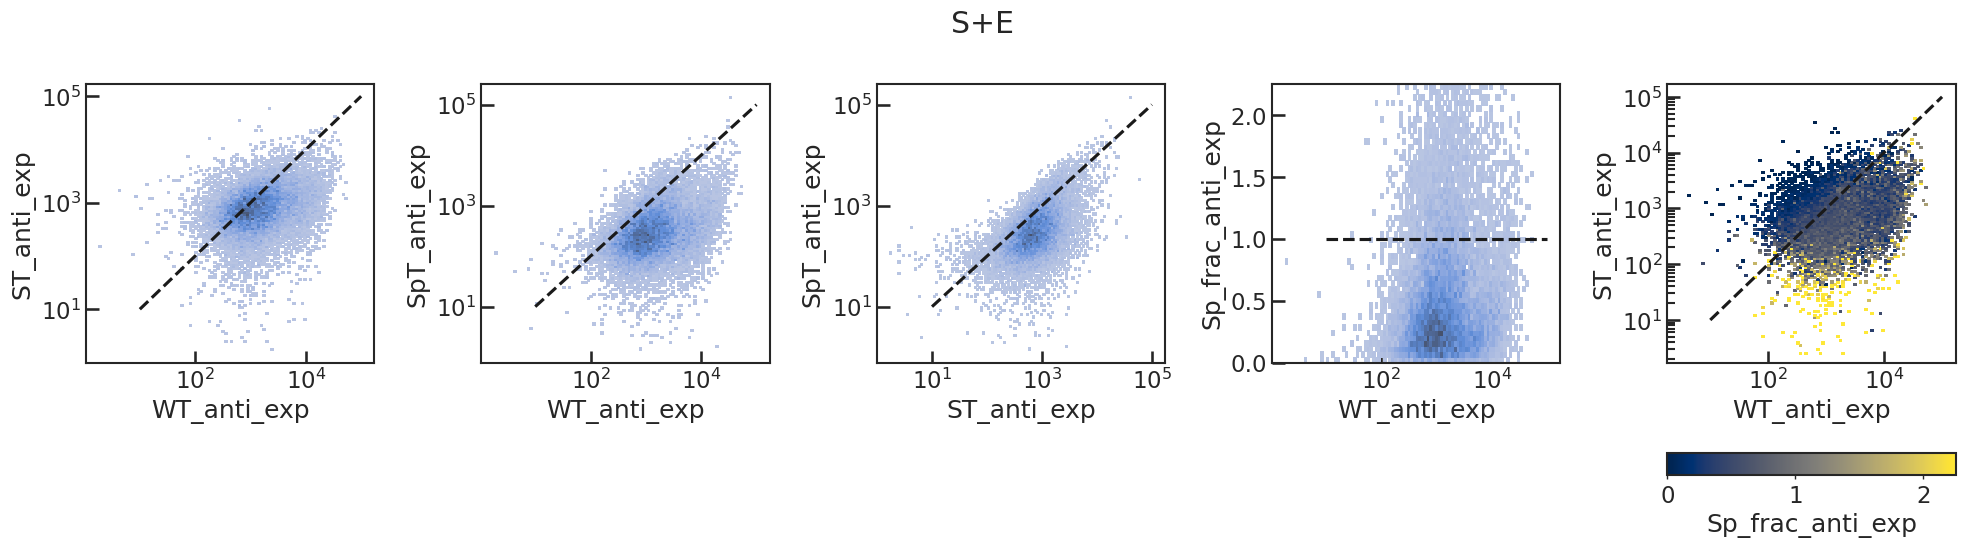

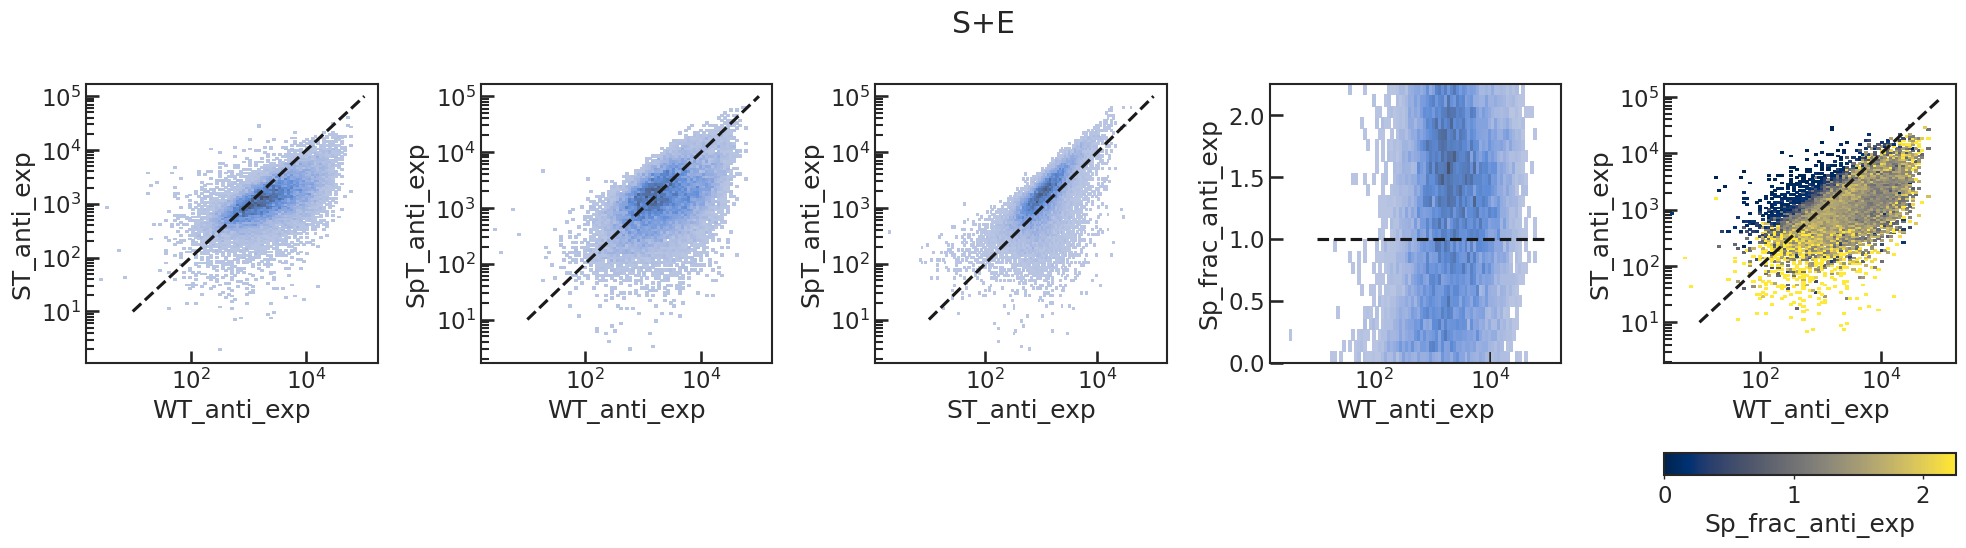

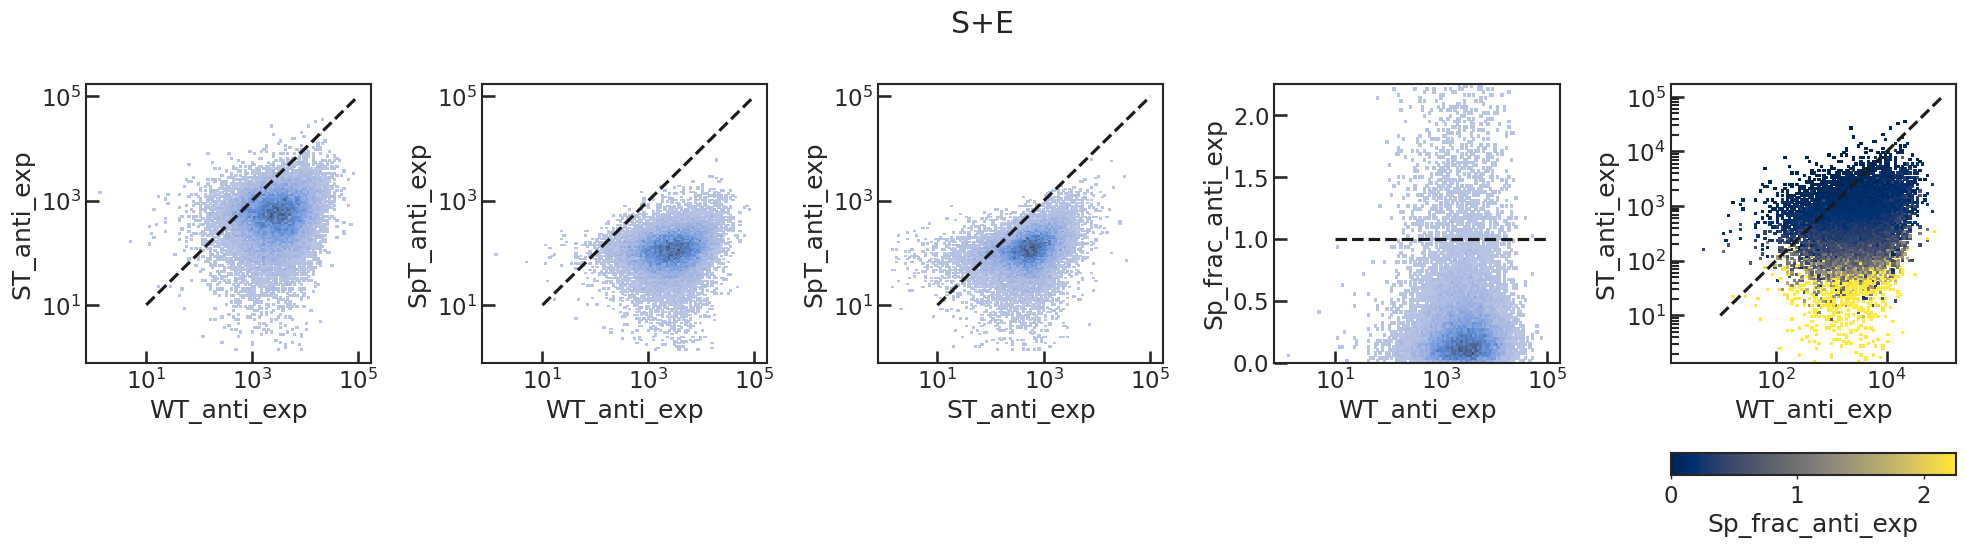

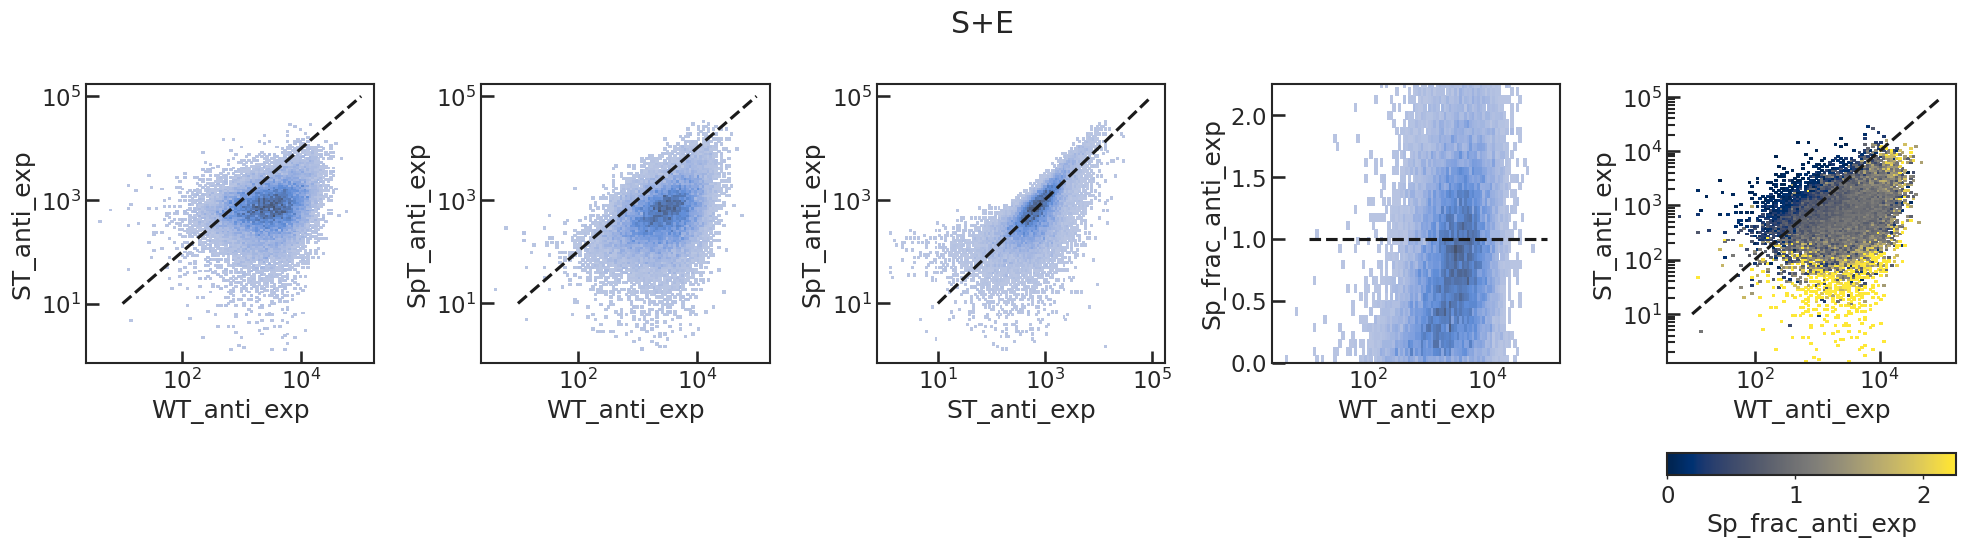

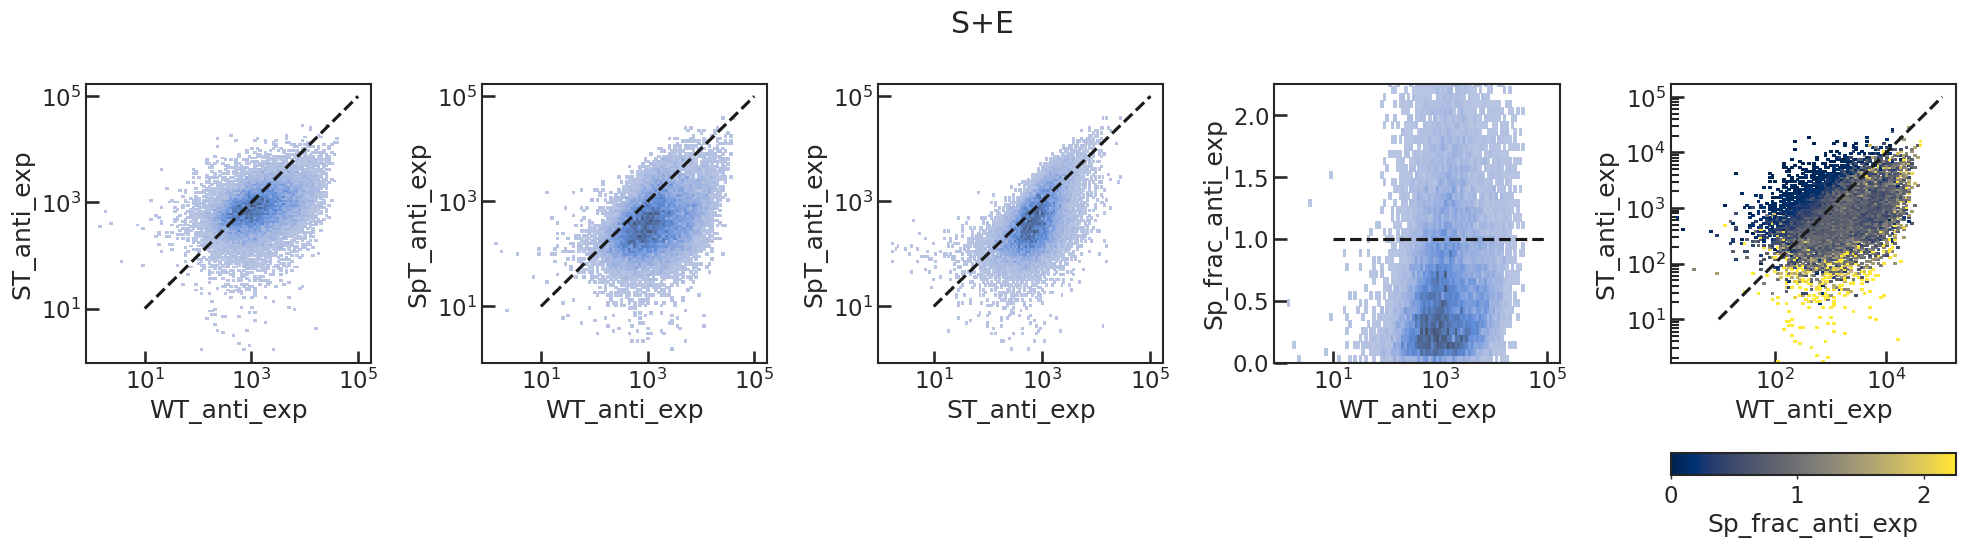

In [103]:


# dataset, zipper variant, kinase variant, model
s_list = [
    ['E+E', 'E+E', 'wt', 'push'],
    ['I+E', 'I+E', 'wt', 'push'],
    ['RR+A', 'RR+A', 'wt', 'push'],
    ['S+A', 'S+A', 'wt', 'push'],
    ['S+E', 'S+E', 'wt', 'push']
         ]

df_info = pd.DataFrame(s_list, columns=['dataset', 'zipper', 'kinase', 'model'])
     
display(df_info)

df_list = []
for index, row in df_info.iterrows():
    df = pd.read_csv("../data/push_data/Zipper Variant/{}.csv".format(row['dataset']))    
    df['dataset'] = row['dataset']      
    df_list.append(df)
    
    
df = pd.concat(df_list).drop("Unnamed: 0", axis=1, errors='ignore')


df.set_index("dataset", inplace=True, append=True)
df = df.reorder_levels(df.index.names[::-1])


print(len(df.index))
df = df[(df[df.columns[:-1]] > 0).all(axis=1)].rename(columns={'WT_anti': 'WT_anti_exp', 'ST_anti': 'ST_anti_exp', 'SpT_anti': 'SpT_anti_exp'})
print(len(df.index))

df['Sp_frac_anti_exp'] = df['SpT_anti_exp'] / df['ST_anti_exp']



display(df)


for index, row in df_info.iterrows():
    dataset = row['dataset']
    
    df_tmp = df.query("dataset==@dataset").copy()
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4.5))

    
    fig.suptitle(construct)
    
    ax = axes[0]
    
    sns.histplot(df_tmp, x='WT_anti_exp', y='ST_anti_exp', 
                 log_scale=(True, True), ax=ax)
    
    
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax = axes[1]
    
    sns.histplot(df_tmp, x='WT_anti_exp', y='SpT_anti_exp', 
                 log_scale=(True, True), ax=ax)
    
        
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    
    ax = axes[2]
    
    sns.histplot(df_tmp, x='ST_anti_exp', y='SpT_anti_exp', 
                 log_scale=(True, True), ax=ax)
    
        
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax = axes[3]
        
    
    sns.histplot(df_tmp, x='WT_anti_exp', y='Sp_frac_anti_exp', 
                 log_scale=(True, False), ax=ax)
    
    ax.hlines(1e0, xmin=1e1, xmax=1e5, color='k', ls='--')
        
    ax.set_ylim(0, group['Sp_frac_anti_exp'].quantile(0.95))
    
    
    ax = axes[4]
    
    
    hist, xedges = np.histogram(np.log10(df_tmp['WT_anti_exp']), bins='auto')
    hist, yedges = np.histogram(np.log10(df_tmp['ST_anti_exp']), bins='auto')
    xedges = 10**xedges
    yedges = 10**yedges

    df_tmp['xbin'] = pd.cut(df_tmp['WT_anti_exp'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_anti_exp'], yedges, labels=False)


    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_anti_exp'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm = mpl.colors.Normalize(vmin=0, vmax=group['Sp_frac_anti_exp'].quantile(0.95))
    cmap=plt.cm.cividis
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap, norm=norm, rasterized=True)
    
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_anti_exp')
    ax.set_ylabel('ST_anti_exp')
        
    
    
    plt.tight_layout()
    
    
    
    bbox = ax.get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Sp_frac_anti_exp")

    

    plt.show()
    
    


Num Cells: 6460 Points per bin: 10 Num Bins: 25
Num Cells: 12085 Points per bin: 10 Num Bins: 34


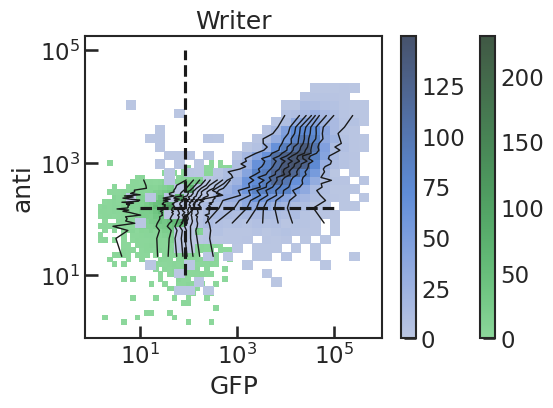

Num Cells: 8469 Points per bin: 10 Num Bins: 29
Num Cells: 12085 Points per bin: 10 Num Bins: 34


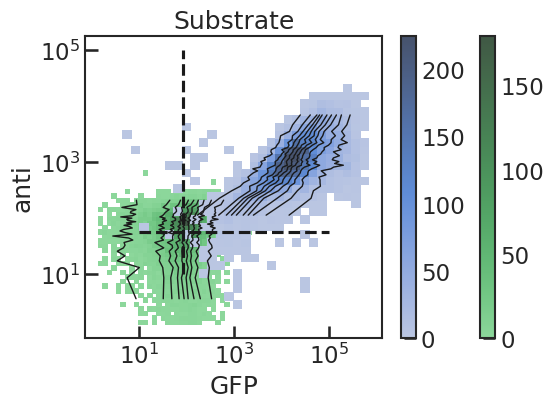

Num Cells: 8469 Points per bin: 10 Num Bins: 29
Num Cells: 12085 Points per bin: 10 Num Bins: 34


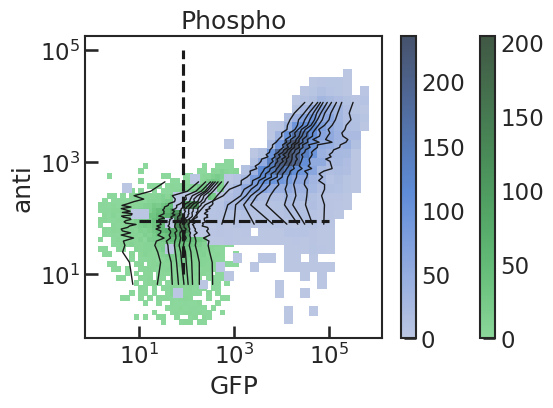

anti           GFP  anti_bin  GFP_bin
0      3667.152344  22898.355470        24        6
1       476.868988   5922.267578         5       12
2        23.291704  14411.395510         0       16
3      1000.184021  26463.156250        12       21
4      1305.120117  56764.875000        15       25
...            ...           ...       ...      ...
20549   107.773010     99.154053        19       18
20550    95.165207     35.085114        16        6
20551   103.868874     76.818558        18       14
20552   151.937317    101.059883        25       17
20553    43.166561     43.098728         5        6

[20554 rows x 4 columns]

Num Cells: 20554 Points per bin: 10 Num Bins: 45


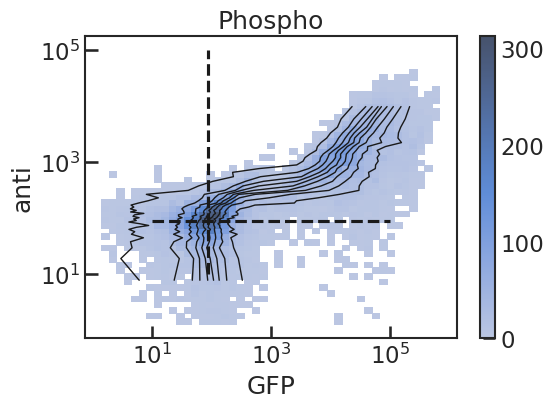

Num Cells: 8469 Points per bin: 10 Num Bins: 29
Num Cells: 12085 Points per bin: 10 Num Bins: 34


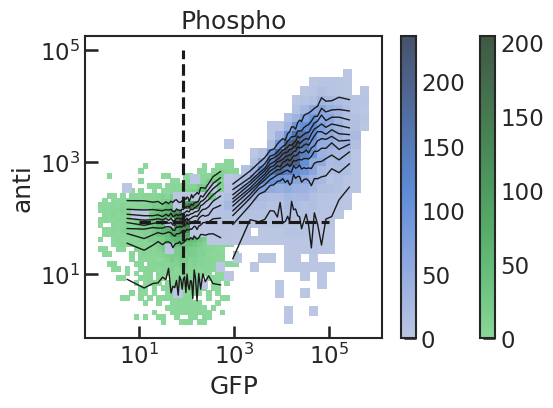

GFP         anti  GFP_bin  anti_bin
0      22898.355470  3667.152344       15        24
1       5922.267578   476.868988        4         6
2      14411.395510    23.291704       11         0
3      26463.156250  1000.184021       17         8
4      56764.875000  1305.120117       23         8
...             ...          ...      ...       ...
20549     99.154053   107.773010       17        20
20550     35.085114    95.165207        5        19
20551     76.818558   103.868874       13        22
20552    101.059883   151.937317       17        27
20553     43.098728    43.166561        6         5

[20554 rows x 4 columns]

Num Cells: 20554 Points per bin: 10 Num Bins: 45


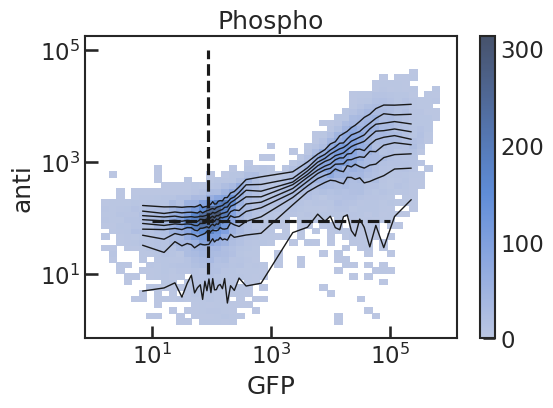

In [82]:
nbins_anti = 100
nbins_GFP = 100

writer_noise = noise.Anti2GFPNoise("../data/noise_data/Flag noise.csv", 
                                   'HA', 'GFP', ppbin=10, verbose=False)

empty_writer_noise = noise.Anti2GFPNoise("../data/noise_data/Empty Cell.csv", 
                                   'HA', 'GFP', ppbin=10, verbose=False)


fig, ax = plt.subplots(1, 1, figsize=(6, 4))
empty_writer_noise.plot(ax, color='g')
writer_noise.plot(ax)

ax.set_title("Writer")

ax.hlines(10**np.mean(np.log10(empty_writer_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

ax.vlines(10**np.mean(np.log10(empty_writer_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')


plt.show()

    
substrate_noise = noise.Anti2GFPNoise("../data/noise_data/Phopho_Myc noise.csv", 
                                   'Myc', 'GFP', ppbin=10, verbose=False)

empty_substrate_noise = noise.Anti2GFPNoise("../data/noise_data/Empty Cell.csv", 
                                   'Myc', 'GFP', ppbin=10, verbose=False)



fig, ax = plt.subplots(1, 1, figsize=(6, 4))
empty_substrate_noise.plot(ax, color='g')
substrate_noise.plot(ax)
ax.set_title("Substrate")

ax.hlines(10**np.mean(np.log10(empty_substrate_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')
ax.vlines(10**np.mean(np.log10(empty_substrate_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')

plt.show()


    
phospho_noise = noise.Anti2GFPNoise("../data/noise_data/Phopho_Myc noise.csv", 
                                   'Phospho', 'GFP', ppbin=10, verbose=False)

empty_phospho_noise = noise.Anti2GFPNoise("../data/noise_data/Empty Cell.csv", 
                                   'Phospho', 'GFP', ppbin=10, verbose=False)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

empty_phospho_noise.plot(ax, color='g')
phospho_noise.plot(ax)
ax.set_title("Phospho")

ax.hlines(10**np.mean(np.log10(empty_phospho_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')
ax.vlines(10**np.mean(np.log10(empty_phospho_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')

plt.show()



phospho_noise.add_cells(empty_phospho_noise)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
phospho_noise.plot(ax)

ax.set_title("Phospho")

ax.hlines(10**np.mean(np.log10(empty_phospho_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

ax.vlines(10**np.mean(np.log10(empty_phospho_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')


plt.show()



inverse_phospho_noise = noise.GFP2AntiNoise("../data/noise_data/Phopho_Myc noise.csv", 
                                   'GFP', 'Phospho', ppbin=10, verbose=False)

inverse_empty_phospho_noise = noise.GFP2AntiNoise("../data/noise_data/Empty Cell.csv", 
                                   'GFP', 'Phospho', ppbin=10, verbose=False)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

inverse_empty_phospho_noise.plot(ax, color='g')
inverse_phospho_noise.plot(ax)
ax.set_title("Phospho")

ax.hlines(10**np.mean(np.log10(inverse_empty_phospho_noise.get_GFP())), xmin=1e1, xmax=1e5, color='k', ls='--')
ax.vlines(10**np.mean(np.log10(inverse_empty_phospho_noise.get_anti())), ymin=1e1, ymax=1e5, color='k', ls='--')

plt.show()



inverse_phospho_noise.add_cells(inverse_empty_phospho_noise)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
inverse_phospho_noise.plot(ax)

ax.set_title("Phospho")

ax.hlines(10**np.mean(np.log10(inverse_empty_phospho_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

ax.vlines(10**np.mean(np.log10(inverse_empty_phospho_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')


plt.show()



0.05261970679546074 [0.05      0.2573546] 0
0.04183228628176966 [0.0200495 0.2573546] 0
0.03950027263612635 [0.0200495  0.21710494] 0
0.03307346784201626 [0.0200495  0.23632288] 0
0.03202982190633963 [0.0200495  0.24044126] 0
0.03174149808917448 [0.0200495  0.24565237] 0
0.030979020814494995 [0.02148458 0.24565237] 0
0.030830329490287522 [0.02148458 0.24611717] 0
0.030830329490286634 [0.02148458 0.24628114] 0
0.030520436621235714 [0.02433514 0.24786465] 0
0.030482827522901323 [0.02395801 0.24786465] 0
0.030469050498477146 [0.02381992 0.24786465] 0
0.030441835428848818 [0.02354724 0.24786465] 0
0.030372315691083673 [0.02394605 0.24856329] 0
0.030333627887926706 [0.02394605 0.2482867 ] 0
0.030321108955264187 [0.02382092 0.2482867 ] 0
0.030321108955263854 [0.02382092 0.24837709] 0
0.030180930224781854 [0.02472916 0.249078  ] 0
0.030180930224781632 [0.02472916 0.24914464] 0
     fun: 0.030180930224781632
 message: ['Maximum number of iteration reached']
    nfev: 8002
    nhev: 0
     nit:

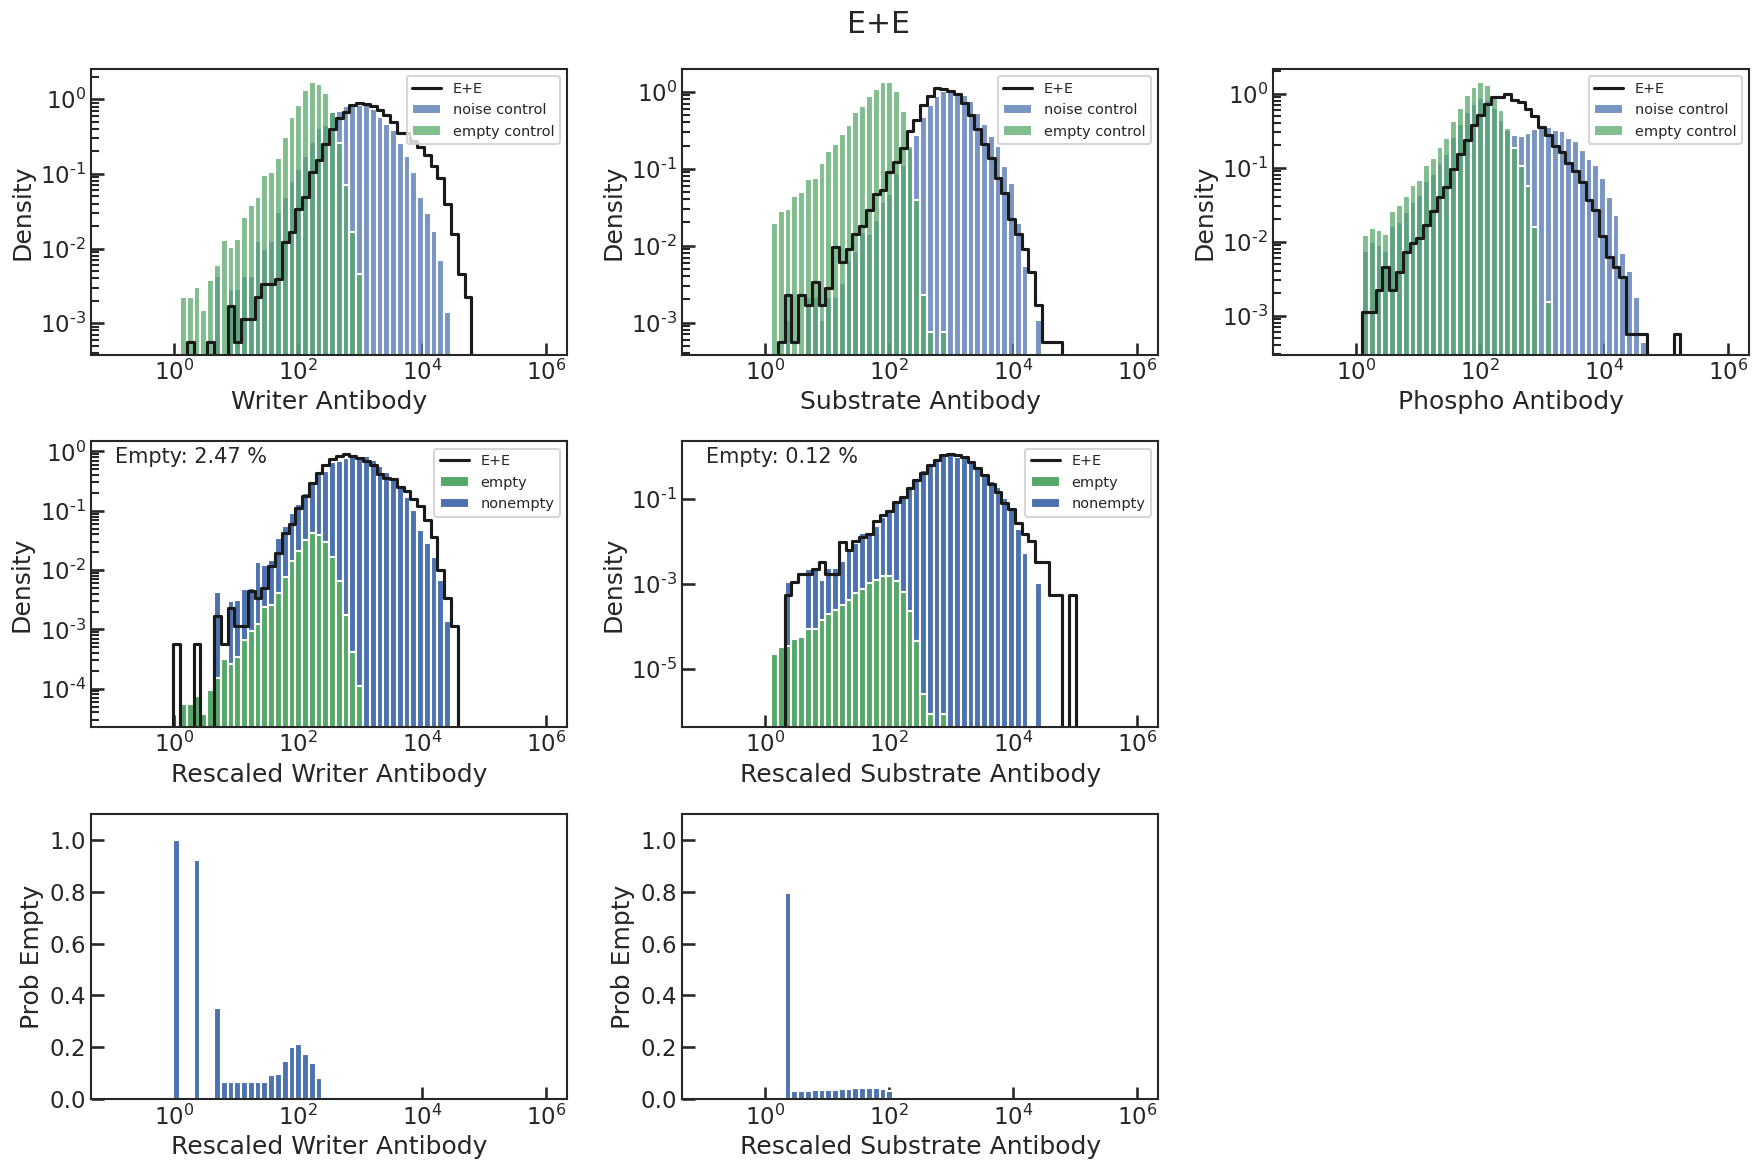

0.14632167481302405 [0.05       0.64035904] 0
0.02087090559572702 [0.05       0.47013779] 0
0.020468126419410315 [0.05       0.47096602] 0
0.018748307120992957 [0.06383494 0.48640894] 0
0.018635119457623944 [0.06383494 0.48626818] 0
0.01837999343920338 [0.06254097 0.48384136] 0
0.018315660009528723 [0.06254097 0.48463449] 0
0.018308546108398716 [0.06254851 0.48463449] 0
0.018250332262090496 [0.06254851 0.48454629] 0
0.018239207828408488 [0.06251529 0.48454629] 0
0.018239207828408432 [0.06251529 0.48452336] 0
     fun: 0.018239207828408432
 message: ['Maximum number of iteration reached']
    nfev: 8002
    nhev: 0
     nit: 2000
    njev: 0
  status: 0
 success: True
       x: array([0.06251529, 0.48452336])
0.06283567371179202 [0.05      0.1078056] 0
0.03775284987319061 [0.01298639 0.06575267] 0
0.02948601847205279 [0.01298639 0.05718688] 0
0.029160771348539005 [0.01379021 0.05718688] 0
0.028592897748767915 [0.01379021 0.05308289] 0
0.02713893307183804 [0.01257043 0.05308289] 0
0.0264

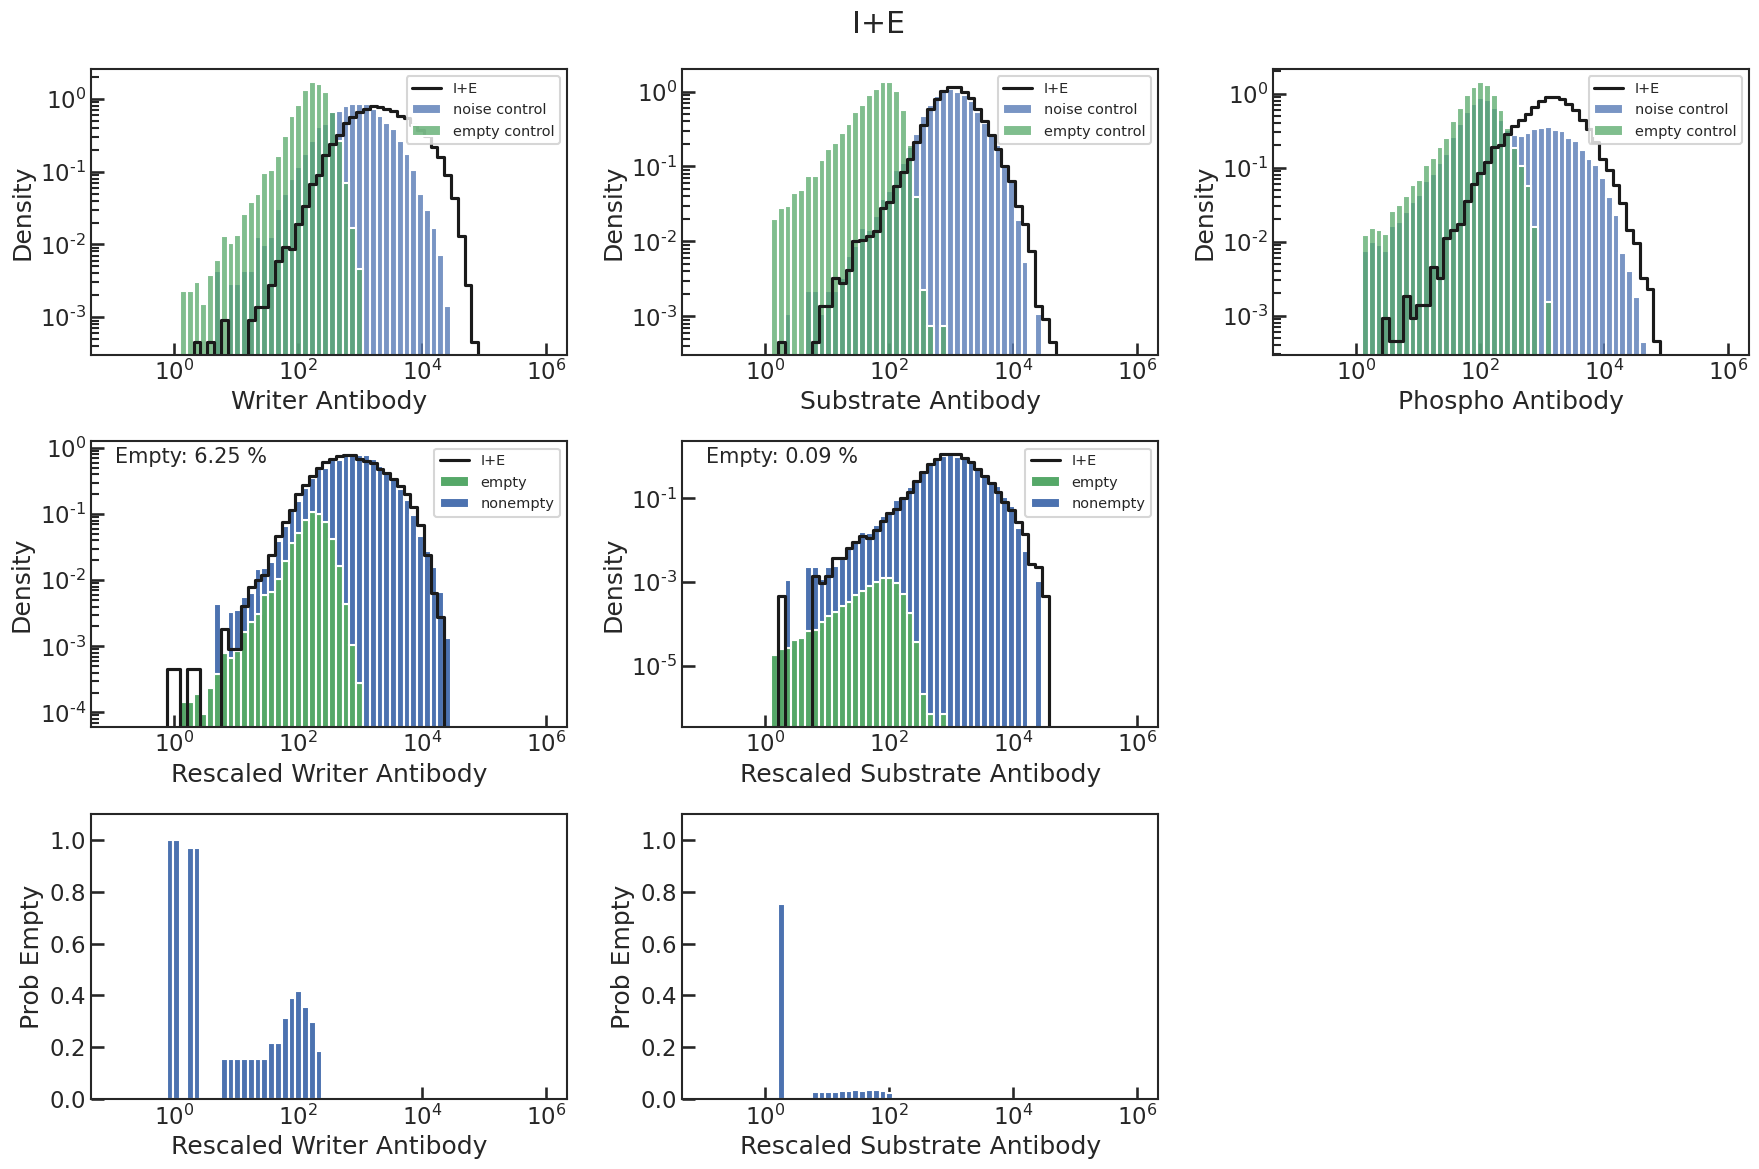

0.16036244586482884 [0.27974786 0.72404302] 0
0.11615044523151696 [0.20624121 0.69445629] 0
0.07104590157555532 [0.15842533 0.69445629] 0
0.07077920527182024 [0.14388354 0.69652844] 0
0.07061044529508853 [0.14388354 0.6963539 ] 0
0.06866919975830732 [0.14388354 0.67556191] 0
0.04989174947868158 [0.04183336 0.59141528] 0
0.04174931580702601 [0.06473225 0.59141528] 0
0.04056057373887012 [0.06473225 0.58821145] 0
0.03991546931353851 [0.06473225 0.58524465] 0
0.033215709509154756 [0.03350302 0.5367389 ] 0
0.0315083034841801 [0.03214646 0.5367389 ] 0
0.02886309133101328 [0.02664207 0.5367389 ] 0
0.02807958085225526 [0.02598212 0.53342685] 0
0.028079580852255148 [0.02598212 0.53354386] 0
0.02771614885591628 [0.02598212 0.53059001] 0
0.027104992233045078 [0.02470548 0.53059001] 0
0.027061204934721694 [0.02470548 0.52903481] 0
0.026736228841334586 [0.02445083 0.52903481] 0
0.026712158728934954 [0.02292383 0.52903481] 0
0.02667785770053499 [0.02310014 0.52903481] 0
0.02607603671212666 [0.021610

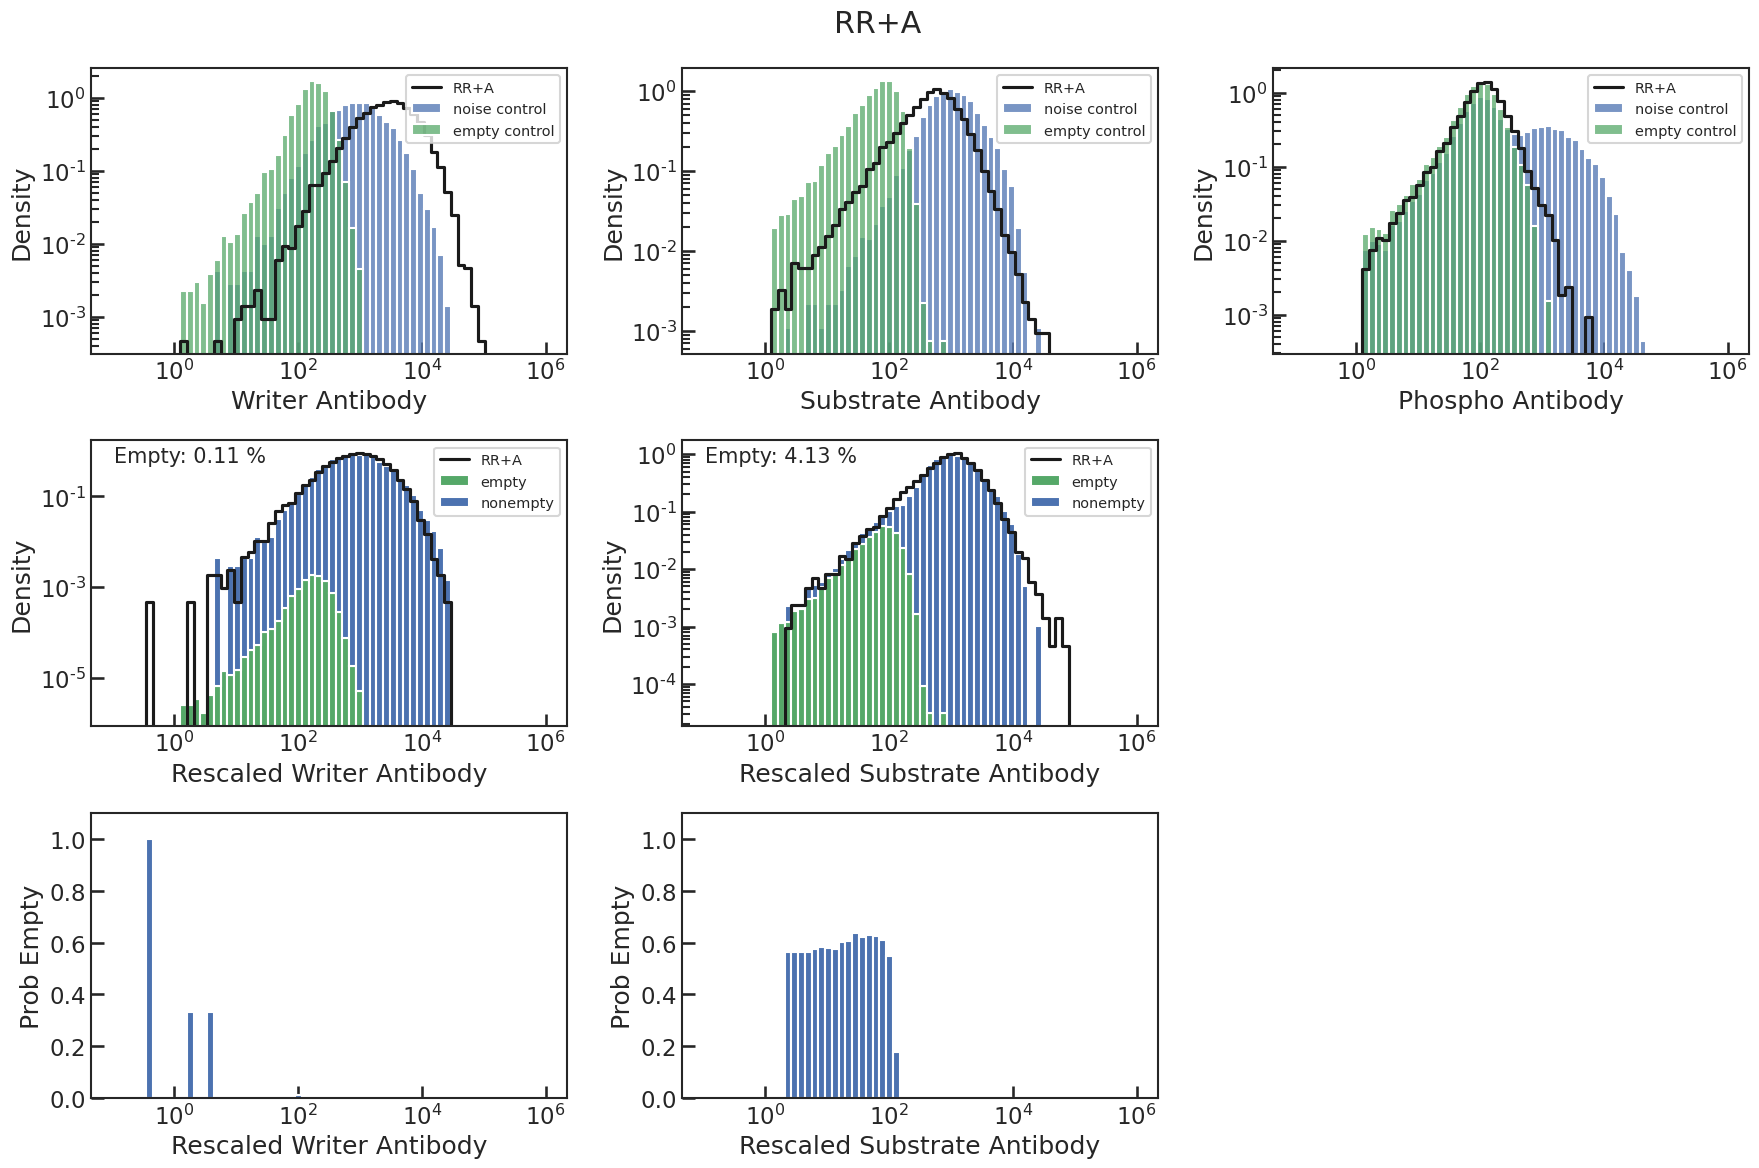

0.28443146264937064 [0.02448545 0.20541188] 0
0.24408290034651087 [0.02448545 0.25430393] 0
0.16722000833316353 [0.07261488 0.77065051] 0
0.11996296241775736 [0.07261488 0.47712597] 0
0.11264827680919542 [0.23009312 0.82358503] 0
0.09072427905363678 [0.23917502 0.7753854 ] 0
0.09039491488839602 [0.22064768 0.7753854 ] 0
0.0899448433178418 [0.22171968 0.7753854 ] 0
0.08589596820260659 [0.22171968 0.76168476] 0
0.08543144958356841 [0.21307207 0.76168476] 0
0.08236099214897863 [0.12037658 0.6872627 ] 0
0.06710453902203717 [0.12037658 0.65880489] 0
0.04862355399460727 [0.04732531 0.57385901] 0
0.04793135796965109 [0.04732531 0.57162968] 0
0.0466347211487278 [0.05433043 0.57162968] 0
0.04575946473573139 [0.06140956 0.57162968] 0
0.04561519860783991 [0.06140956 0.57225478] 0
0.04227739340102932 [0.05016992 0.5590481 ] 0
0.042277393401029095 [0.05016992 0.5587807 ] 0
0.03635005304999628 [0.01915269 0.52657126] 0
0.032146900030162184 [0.01915269 0.51801497] 0
0.031513482815529015 [0.01915269 0

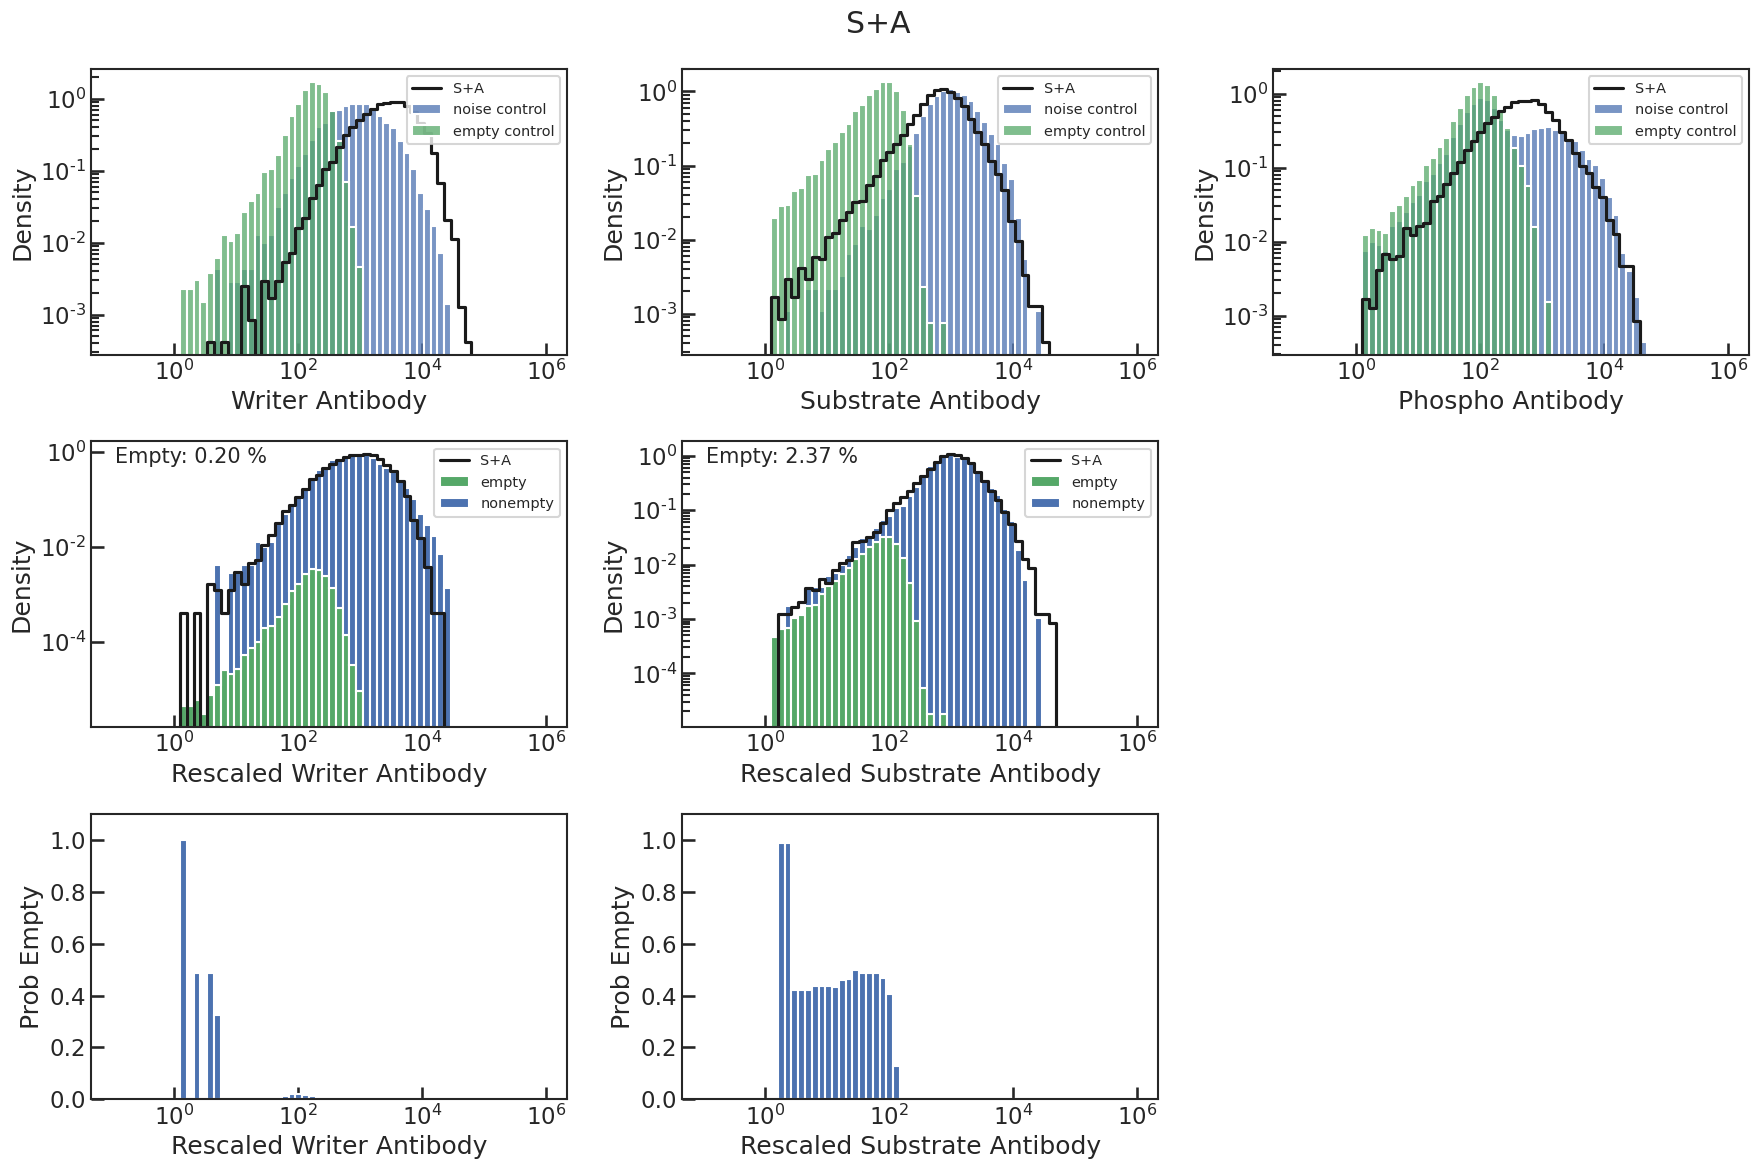

0.1891125621227817 [0.84683393 0.79683393] 0
0.11381640965964968 [0.57082434 0.79683393] 0
0.037154685031733026 [0.03990142 0.26591102] 0
0.033377559631548925 [0.04377079 0.26591102] 0
0.02981092651820752 [0.05611591 0.26591102] 0
0.026160424987677122 [0.05123467 0.26591102] 0
0.025806632677819796 [0.05123467 0.26521032] 0
0.025462139271430456 [0.05123467 0.26462119] 0
0.02543548449051508 [0.05117716 0.26462119] 0
0.024945475694166386 [0.04339928 0.25539219] 0
0.02339578377005619 [0.03936566 0.24895029] 0
0.02249863700747412 [0.03936566 0.24808009] 0
0.02247353458845286 [0.03939189 0.24808009] 0
0.02246713536036221 [0.03942266 0.24808009] 0
0.021987430723541257 [0.0371142  0.24460217] 0
0.021981924390107155 [0.03708805 0.24460217] 0
     fun: 0.021981924390107155
 message: ['Maximum number of iteration reached']
    nfev: 8002
    nhev: 0
     nit: 2000
    njev: 0
  status: 0
 success: True
       x: array([0.03708805, 0.24460217])
0.10053043600374001 [0.07642764 0.        ] 0
0.09470

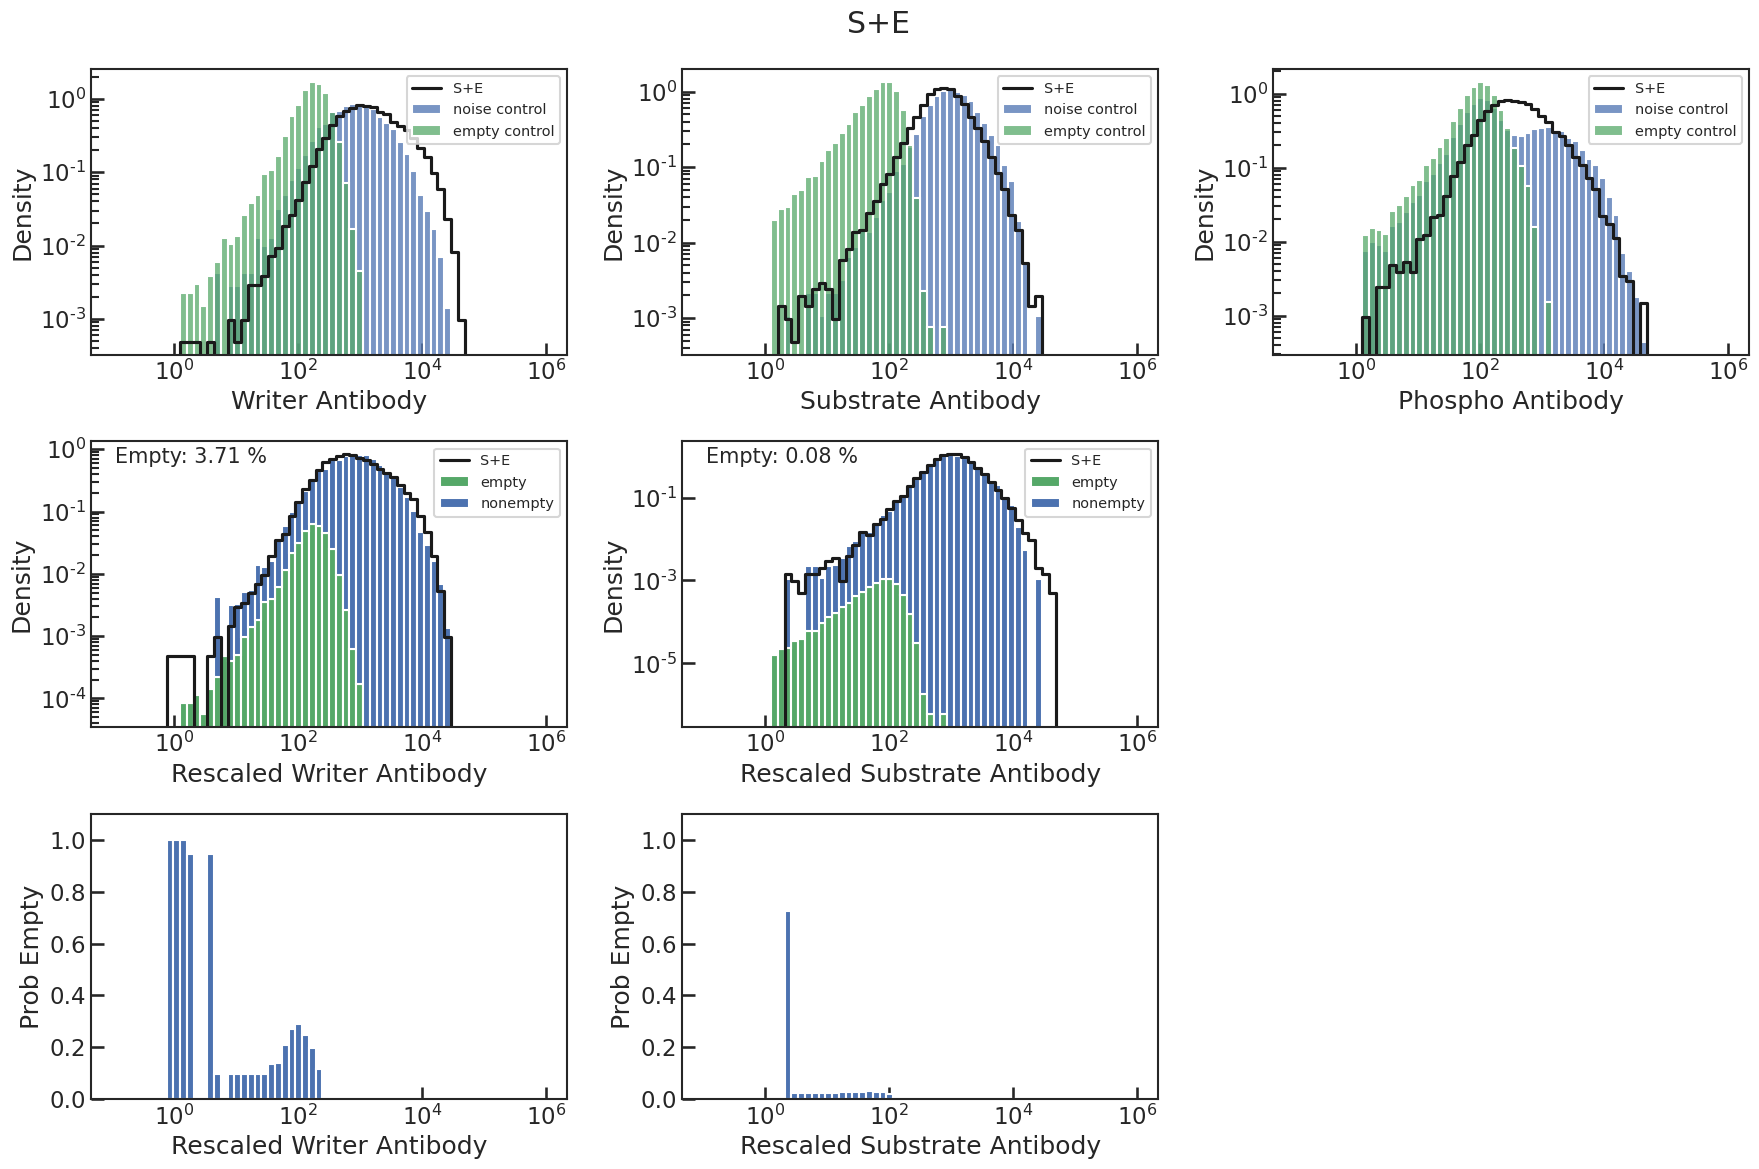

In [105]:
binrange = (-1, 6)

for index, row in df_info.iterrows():
    dataset = row['dataset']
    
    df_tmp = df.query("dataset==@dataset").copy()
    
    fig = plt.figure(figsize=(18, 12))
    
    fig.suptitle(dataset)
    
    ax = fig.add_subplot(3, 3, 1)
    
    sns.histplot(df_tmp['WT_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    sns.histplot(writer_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='noise control', color='b', stat='density')
    sns.histplot(empty_writer_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')
        
    ax.set_xlabel("Writer Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
    
    ax.set_yscale('log')
    
    ################################################################
    
    
    (writer_empty_frac, writer_anti_scale) = noise.calc_mixture(df_tmp['WT_anti_exp'], 
                                                                empty_writer_noise, writer_noise)

        
    df.loc[df_tmp.index, 'WT_anti_rescaled'] = df_tmp['WT_anti_exp'] / 10**writer_anti_scale
        
        
    ax = fig.add_subplot(3, 3, 4, sharex=ax)
            
    
    
    sns.histplot(df.loc[df_tmp.index, 'WT_anti_rescaled'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    
    
    nonempty_hist, edges = np.histogram(np.log10(writer_noise.get_anti()), range=binrange, bins=64)
    nonempty_norm = np.sum(nonempty_hist*(edges[1:]-edges[0:len(edges)-1]))
    
    empty_hist, edges = np.histogram(np.log10(empty_writer_noise.get_anti()), range=binrange, bins=64)
    empty_norm = np.sum(empty_hist*(edges[1:]-edges[0:len(edges)-1]))

    ax.hist([10**edges[:-1], 10**edges[:-1]], 10**edges, 
            weights=[empty_hist/empty_norm*writer_empty_frac, nonempty_hist/nonempty_norm*(1-writer_empty_frac)], 
            histtype='barstacked', color=['g', 'b'], label=['empty', 'nonempty'])
    
        
    ax.set_xlabel("Rescaled Writer Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
    
    ax.set_yscale('log')
    
    ax.text(0.05, 0.98, "Empty: {0:.2f} %".format(100*writer_empty_frac), transform=ax.transAxes,
           va='top', ha='left', fontsize='small')
    
    
    
    ################################################################
    
    df.loc[df_tmp.index, 'WT_prob_empty'] = noise.calc_prob_empty(df.loc[df_tmp.index, 'WT_anti_rescaled'], 
                                                                 writer_empty_frac, 
                                                                 empty_writer_noise, writer_noise)
    
    ax = fig.add_subplot(3, 3, 7, sharex=ax)
    
    df_tmp = df_tmp.copy()
    df_tmp['bin'] = pd.cut(df.loc[df_tmp.index, 'WT_anti_rescaled'], 10**edges, labels=False)
    df_tmp['prob_empty'] = df.loc[df_tmp.index, 'WT_prob_empty']    
    
    hist_corr = df_tmp.groupby(['bin'])['prob_empty'].mean().to_frame("mean")
    
    hist_corr =  hist_corr.reindex(pd.Index(np.arange(len(edges)-1), name='bin', fill_value=np.nan))['mean'].values
    hist_corr = np.nan_to_num(hist_corr)

    ax.hist(10**edges[:-1], 10**edges, weights=hist_corr, histtype='bar', color='b')
    
    ax.set_ylim(0, 1.1)
    
    ax.set_xlabel("Rescaled Writer Antibody")
    ax.set_ylabel("Prob Empty")
    
    
    ################################################################
    
    
    
    ax = fig.add_subplot(3, 3, 2)
        
    sns.histplot(df_tmp['ST_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    sns.histplot(substrate_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='noise control', color='b', stat='density')
    sns.histplot(empty_substrate_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')

    ax.set_xlabel("Substrate Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
    
    ax.set_yscale('log')
    
    
    ################################################################
    
    (substrate_empty_frac, substrate_anti_scale) = noise.calc_mixture(df_tmp['ST_anti_exp'], 
                                                                empty_substrate_noise, substrate_noise)

        
    ax = fig.add_subplot(3, 3, 5, sharex=ax)
            
    df.loc[df_tmp.index, 'ST_anti_rescaled'] = df_tmp['ST_anti_exp'] / 10**substrate_anti_scale
    
    sns.histplot(df.loc[df_tmp.index, 'ST_anti_rescaled'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    
    
    nonempty_hist, edges = np.histogram(np.log10(substrate_noise.get_anti()), range=binrange, bins=64)
    nonempty_norm = np.sum(nonempty_hist*(edges[1:]-edges[0:len(edges)-1]))
    
    empty_hist, edges = np.histogram(np.log10(empty_substrate_noise.get_anti()), range=binrange, bins=64)
    empty_norm = np.sum(empty_hist*(edges[1:]-edges[0:len(edges)-1]))

    ax.hist([10**edges[:-1], 10**edges[:-1]], 10**edges, 
            weights=[empty_hist/empty_norm*substrate_empty_frac, nonempty_hist/nonempty_norm*(1-substrate_empty_frac)], 
            histtype='barstacked', color=['g', 'b'], label=['empty', 'nonempty'])
    
        
    ax.set_xlabel("Rescaled Substrate Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
    
    ax.set_yscale('log')
      
    ax.text(0.05, 0.98, "Empty: {0:.2f} %".format(100*substrate_empty_frac), transform=ax.transAxes,
           va='top', ha='left', fontsize='small')
    
    
    ################################################################
    
    df.loc[df_tmp.index, 'ST_prob_empty'] = noise.calc_prob_empty(df.loc[df_tmp.index, 'ST_anti_rescaled'], 
                                                                 substrate_empty_frac, 
                                                                 empty_substrate_noise, substrate_noise)
    
    ax = fig.add_subplot(3, 3, 8, sharex=ax)
    
    df_tmp['bin'] = pd.cut(df.loc[df_tmp.index, 'ST_anti_rescaled'], 10**edges, labels=False)
    df_tmp['prob_empty'] = df.loc[df_tmp.index, 'ST_prob_empty']    
    
    hist_corr = df_tmp.groupby(['bin'])['prob_empty'].mean().to_frame("mean")
    
    hist_corr =  hist_corr.reindex(pd.Index(np.arange(len(edges)-1), name='bin', fill_value=np.nan))['mean'].values
    hist_corr = np.nan_to_num(hist_corr)

    ax.hist(10**edges[:-1], 10**edges, weights=hist_corr, histtype='bar', color='b')
    
    ax.set_ylim(0, 1.1)
    
    ax.set_xlabel("Rescaled Substrate Antibody")
    ax.set_ylabel("Prob Empty")
    
    
    ################################################################
    
    ax = fig.add_subplot(3, 3, 3)
    
    sns.histplot(df_tmp['SpT_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    sns.histplot(phospho_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='noise control', color='b', stat='density')
    sns.histplot(empty_phospho_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')

    ax.set_xlabel("Phospho Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
        
    ax.set_yscale('log')
        
    plt.tight_layout()
    
    plt.show()


In [106]:

zero = 1e-8

for dataset, group in df.groupby("dataset"):
    
    
    
    # convert antibody measurements to GFP measurements
    GFP_infer, anti_bin, GFP_bin = writer_noise.anti_to_GFP(df.loc[group.index, 'WT_anti_rescaled'])
    df.loc[group.index, 'WT_GFP_infer'] = GFP_infer
    df.loc[group.index, 'WT_anti_bin'] = anti_bin
    df.loc[group.index, 'WT_GFP_bin'] = GFP_bin
    df.loc[group.index, 'WT_conc_infer'] = np.maximum(df.loc[group.index, 'WT_GFP_infer'] - np.median(empty_writer_noise.get_GFP()), zero)

    GFP_infer, anti_bin, GFP_bin = substrate_noise.anti_to_GFP(df.loc[group.index, 'ST_anti_rescaled'])
    df.loc[group.index, 'ST_GFP_infer'] = GFP_infer
    df.loc[group.index, 'ST_anti_bin'] = anti_bin
    df.loc[group.index, 'ST_GFP_bin'] = GFP_bin
    df.loc[group.index, 'ST_conc_infer'] = np.maximum(df.loc[group.index, 'ST_GFP_infer'] - np.median(empty_substrate_noise.get_GFP()), zero)

    
    GFP_infer, anti_bin, GFP_bin = phospho_noise.anti_to_GFP(df.loc[group.index, 'SpT_anti_exp'])
    df.loc[group.index, 'SpT_GFP_infer'] = GFP_infer
#     df.loc[group.index, 'SpT_anti_bin'] = anti_bin
#     df.loc[group.index, 'SpT_GFP_bin'] = GFP_bin
    df.loc[group.index, 'SpT_conc_infer'] = np.maximum(df.loc[group.index, 'SpT_GFP_infer'] - np.median(empty_phospho_noise.get_GFP()), zero)

    df.loc[group.index, 'Sp_frac_GFP_infer'] = df.loc[group.index, 'SpT_GFP_infer'] / df.loc[group.index, 'ST_GFP_infer']
    df.loc[group.index, 'Sp_frac_conc_infer'] = df.loc[group.index, 'SpT_conc_infer'] / df.loc[group.index, 'ST_conc_infer']
    
    
    df.loc[group.index, 'total_prob_empty'] = 1.0 - (1-df.loc[group.index, 'ST_prob_empty'])*(1-df.loc[group.index, 'WT_prob_empty'])
    
    
print(len(df))
print(len(df.dropna()))

# display(df.groupby(['dataset', 'WT_anti_bin', 'WT_GFP_bin', 'ST_anti_bin', 'ST_GFP_bin']).size())

96261
96261


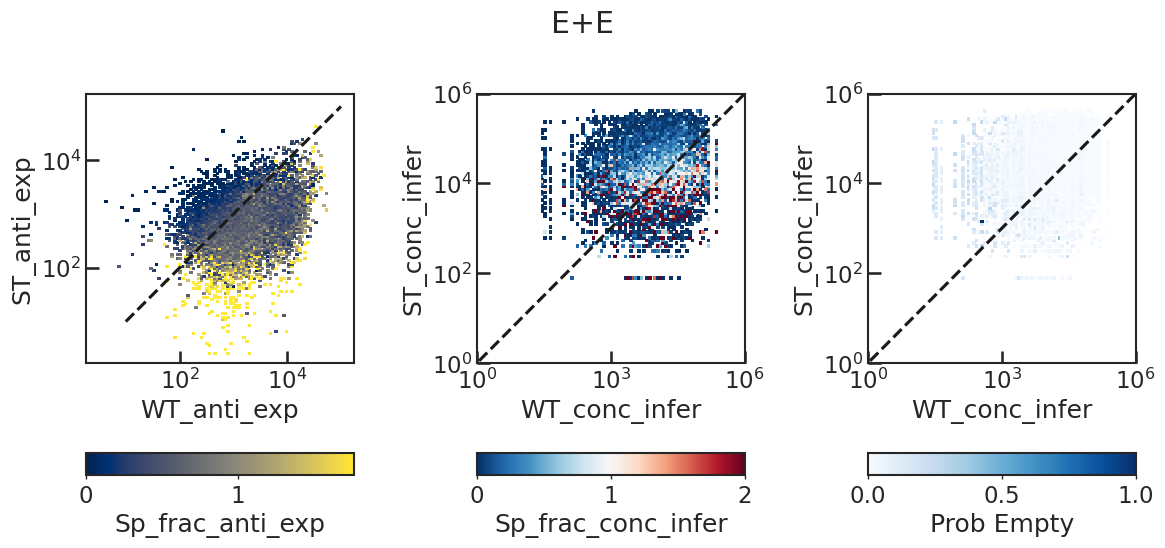

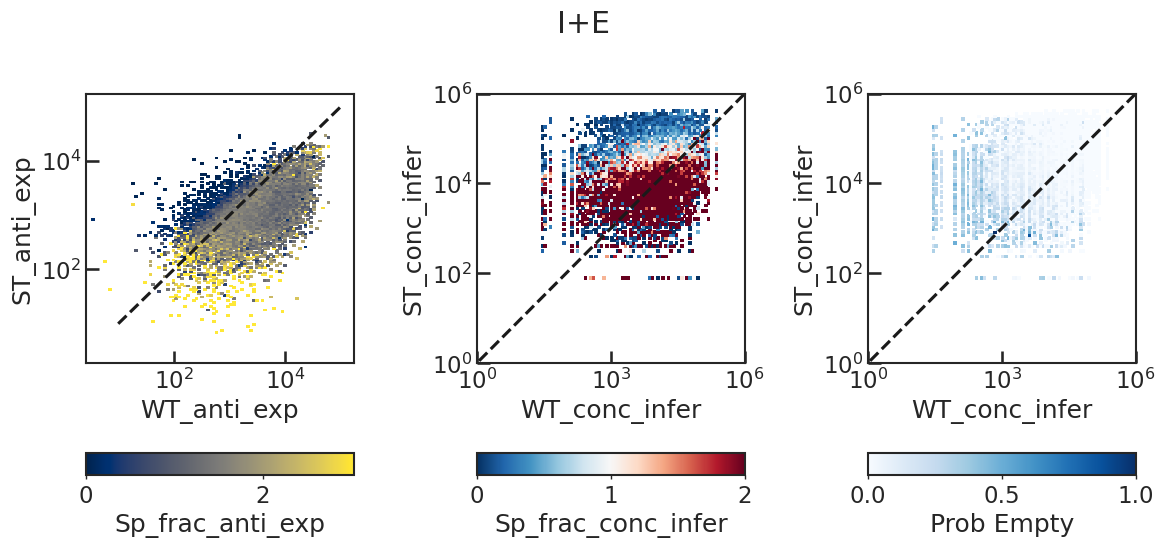

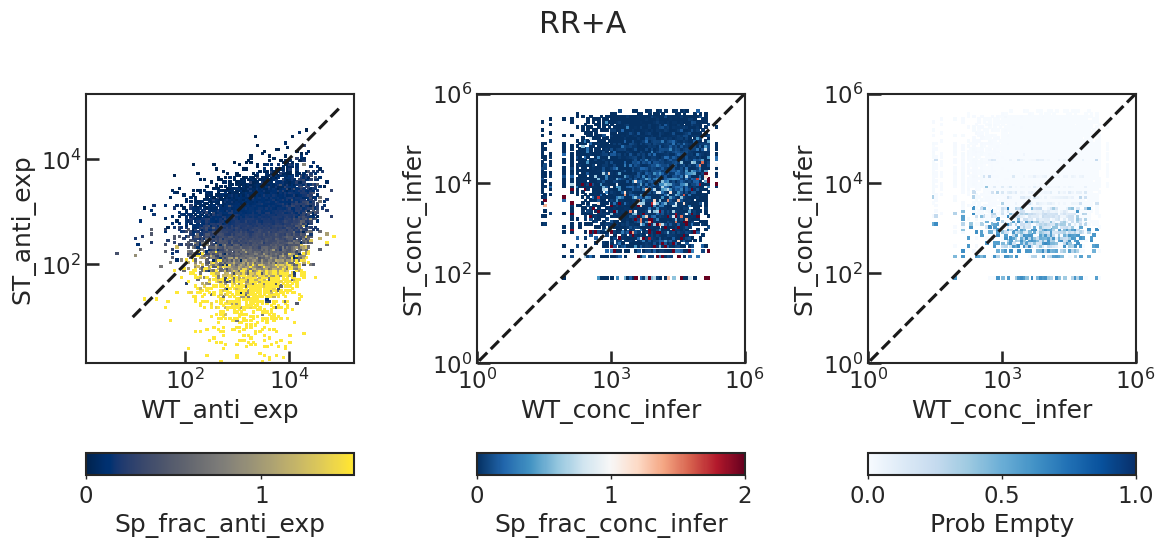

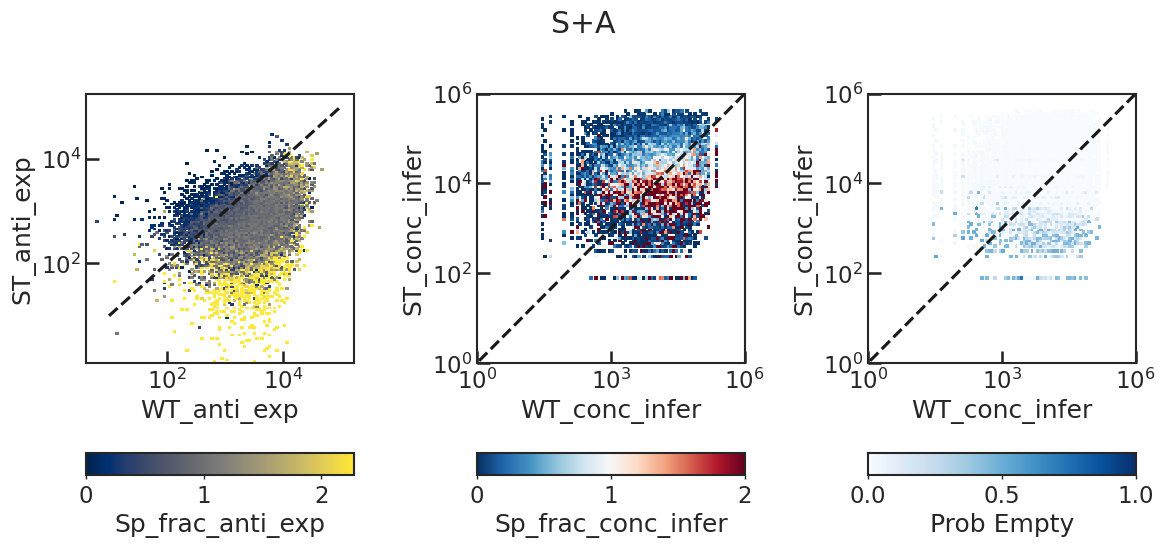

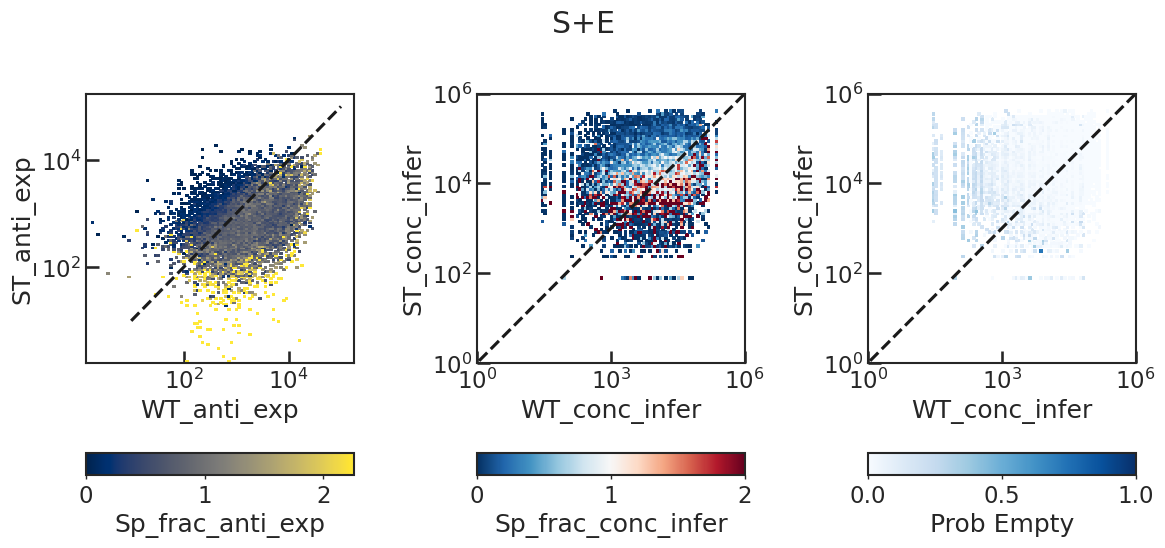

In [107]:



for i, (dataset, group) in enumerate(df.groupby("dataset")):
    
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4.5))
    
    ax = axes[0]
    
    df_tmp = group.copy()
    
    hist, xedges = np.histogram(np.log10(df_tmp['WT_anti_exp']), bins='auto')
    hist, yedges = np.histogram(np.log10(df_tmp['ST_anti_exp']), bins='auto')
    xedges = 10**xedges
    yedges = 10**yedges

    df_tmp['xbin'] = pd.cut(df_tmp['WT_anti_exp'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_anti_exp'], yedges, labels=False)


    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_anti_exp'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm1 = mpl.colors.Normalize(vmin=0, vmax=group['Sp_frac_anti_exp'].quantile(0.95))
    cmap1=plt.cm.cividis
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap1, norm=norm1, rasterized=True)
    
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_anti_exp')
    ax.set_ylabel('ST_anti_exp')
    
    
    ax = axes[1]
    
    df_tmp = group.copy().dropna()
        
    hist, xedges = np.histogram(np.log10(df_tmp['WT_conc_infer']), bins=100, range=(0, 6))
    hist, yedges = np.histogram(np.log10(df_tmp['ST_conc_infer']), bins=100, range=(0, 6))
    xedges = 10**xedges
    yedges = 10**yedges

#     xedges = writer_bins
#     yedges = substrate_bins

    df_tmp['xbin'] = pd.cut(df_tmp['WT_conc_infer'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_conc_infer'], yedges, labels=False)
    

    
    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_conc_infer'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm2 = mpl.colors.Normalize(vmin=0, vmax=2.0)
    cmap2=plt.cm.RdBu_r
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap2, norm=norm2, rasterized=True)
    
    t = np.linspace(1e-1, 1e6)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_conc_infer')
    ax.set_ylabel('ST_conc_infer')
    
    
    
    ax = axes[2]
    
 
    
    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['total_prob_empty'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm3 = mpl.colors.Normalize(vmin=0, vmax=1.0)
    cmap3=plt.cm.Blues
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap3, norm=norm3, rasterized=True)
    
    t = np.linspace(1e-1, 1e6)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_conc_infer')
    ax.set_ylabel('ST_conc_infer')
    
    

    fig.suptitle(dataset)
    
    
    plt.tight_layout()
    
    
    
    bbox = axes[0].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap1, norm=norm1, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Sp_frac_anti_exp")
    
    
    bbox = axes[1].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap2, norm=norm2, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Sp_frac_conc_infer")
    
    
    bbox = axes[2].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap3, norm=norm3, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Prob Empty")
    
    

    plt.show()
    

In [87]:
def solve(df_data, df_info, param_dict, x0, bounds, verbose=False):
    
    df_copy = df.dropna().copy()
    
    if verbose:
        start = time.time()

    loss_dict = {}
    def func(x):
                        
        loss = 0.0
        
        
        
        for index, row in df_info.iterrows():
            dataset = row['dataset']
            
            construct = row['construct']
            
            model_params = 10**np.array(x)[param_dict[construct][0:]]
                
            df_data = df_copy.query("dataset=='{}'".format(dataset))
            
#            
            if row['model'] == 'push':
                            
            
                df_copy.loc[df_data.index, 'SpT_conc_predict'] = pp.PushAmp().predict_all(df_data[['WT_conc_infer', 'ST_conc_infer']].values, model_params)[:, 0]
            
                       
            df_copy.loc[df_data.index, 'SpT_GFP_predict'] = df_copy.loc[df_data.index, 'SpT_conc_predict'] + np.median(empty_phospho_noise.get_GFP())
            
            loss_dict[dataset] = np.mean((np.log10(df_copy.loc[df_data.index, 'SpT_GFP_predict'])-np.log10(df_copy.loc[df_data.index, 'SpT_GFP_infer']))**2)
            
            prob_empty = df_copy.loc[df_data.index, 'total_prob_empty']  
            
            loss += np.mean((1-prob_empty)*(np.log10(df_copy.loc[df_data.index, 'SpT_GFP_predict'])-np.log10(df_copy.loc[df_data.index, 'SpT_GFP_infer']))**2)
            
            
        loss += 1e-6*np.sum((x-np.array(x0))**2)
        return loss




    print("Initial Loss:", func(x0))

    def callback(x):
        print(func(x), 1e-6*np.sum((x-np.array(x0))**2), x)
#         print(loss_dict)

    res = opt.minimize(func, x0, method='L-BFGS-B', 
                       jac='2-point', bounds=bounds, 
                       options={'iprint':101, 'eps': 1e-6, 
                                'gtol': 1e-6, 'ftol':1e-6},
                      callback=callback)
    

    print("Final Loss:", res.fun, func(res.x))

    end = time.time()

    print("Time Elapsed", end-start, "seconds")

    print(res)
        
    
    return res

In [88]:
param_dict = {}

param_labels = [r"$\log_{10}(v_{bg}^p)$", r"$\log_{10}(v_{WS}^p)$"]
x0 = [-1.0, 0.0]
bounds = [(None, None), (None, None)]
# bounds = [(-3, 1), (-3, 3)]

param_index = 1
for index, row in df_info.iterrows():
    
    construct = row['construct']
    model = row['model']
                
    if construct not in param_dict:
        if model == 'background':
            param_dict[construct] = [0]

        elif model == 'push':
            param_dict[construct] = [0, 1, param_index+1]
            param_index += 1
            
            param_labels.append(construct + ": " + r"$\log_{10}(\alpha_{WS})$")
            x0.append(4.0)
            bounds.append((None, None))
        

print(param_labels)
print(param_dict)

print(x0)
print(bounds)

res = solve(df, df_info, param_dict, x0, bounds, verbose=True)


['$\\log_{10}(v_{bg}^p)$', '$\\log_{10}(v_{WS}^p)$', 'E+E: $\\log_{10}(\\alpha_{WS})$', 'I+E: $\\log_{10}(\\alpha_{WS})$', 'RR+A: $\\log_{10}(\\alpha_{WS})$', 'S+A: $\\log_{10}(\\alpha_{WS})$', 'S+E: $\\log_{10}(\\alpha_{WS})$']
{'E+E': [0, 1, 2], 'I+E': [0, 1, 3], 'RR+A': [0, 1, 4], 'S+A': [0, 1, 5], 'S+E': [0, 1, 6]}
[-1.0, 0.0, 4.0, 4.0, 4.0, 4.0, 4.0]
[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]
Initial Loss: 7.880914758423318
6.580615758234381 1.0000000000000002e-06 [-1.56277595 -0.80966462  4.06373513  3.94786133  4.13785123  4.02031434
  4.03911776]
6.514472491147415 8.949099615359592e-07 [-1.55706144 -0.71622654  4.07155741  3.86604138  4.21862751  3.99003925
  4.02548486]
6.2737172433137784 3.0505509806745365e-06 [-1.7736232  -0.04294658  4.18112329  3.00527114  5.14785177  3.68346477
  3.89918177]
5.885743850917721 4.4266449738952e-06 [-1.83280031 -0.12876209  4.23029667  2.8074849   5.44320912  3.61962061
  3.88236035]
5.

[2.35325642e-03 4.27061232e+00 1.23843935e+06]


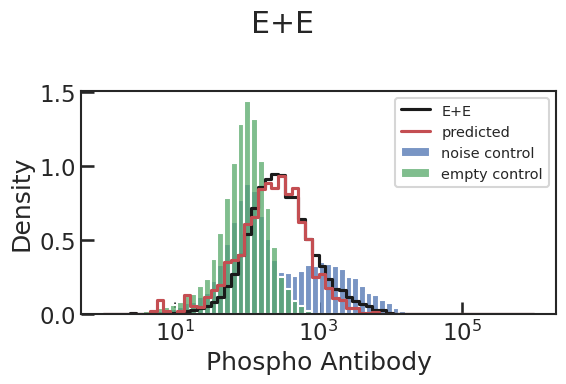

[2.35325642e-03 4.27061232e+00 5.60889895e+00]


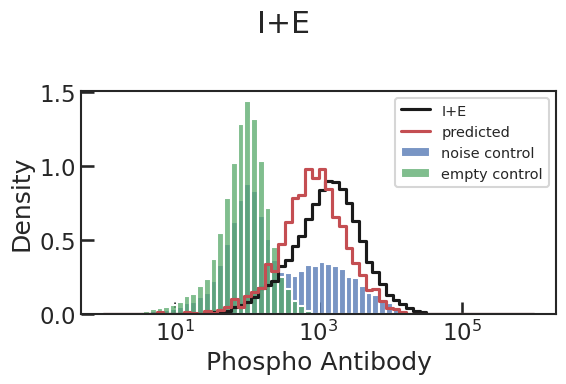

[2.35325642e-03 4.27061232e+00 3.62871517e+08]


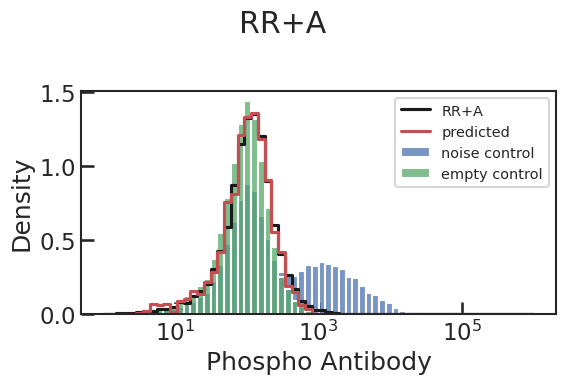

[2.35325642e-03 4.27061232e+00 1.69335278e+05]


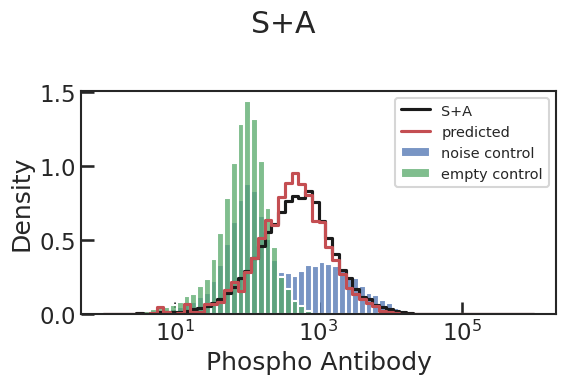

[2.35325642e-03 4.27061232e+00 4.37902860e+05]


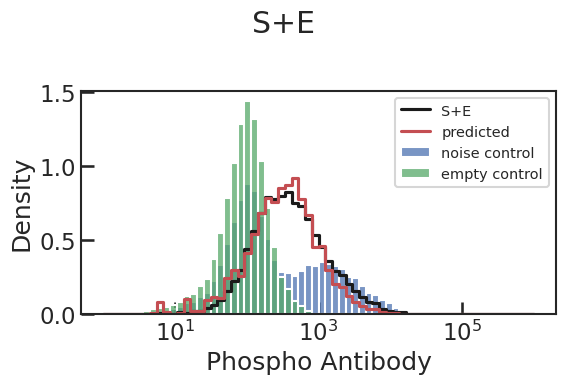

In [95]:
binrange = (0, 6)

for i, (construct, group) in enumerate(df.groupby("dataset")):
    
    model_params = 10**res.x[param_dict[construct][0:]]
    
    print(model_params)
    
    df.loc[group.index, 'SpT_conc_predict'] = pp.PushAmp().predict_all(group[['WT_conc_infer', 'ST_conc_infer']].values, model_params)[:, 0]
    df.loc[group.index, 'SpT_GFP_predict'] = df.loc[group.index, 'SpT_conc_predict'] + 10**np.mean(np.log10(empty_phospho_noise.get_GFP()))
    
    anti, GFP_bins, anti_bins = inverse_phospho_noise.GFP_to_anti(df.loc[group.index, 'SpT_GFP_predict'])
    
    df.loc[group.index, 'SpT_anti_predict'] = anti
    
    df.loc[group.index, 'Sp_frac_conc_predict'] = df.loc[group.index, 'SpT_conc_predict'] / group['ST_conc_infer']
    
    
    fig, axes = plt.subplots(1, 1, figsize=(6, 4))
    
    fig.suptitle(construct)

    
    ax = axes
    
    sns.histplot(df.loc[group.index, 'SpT_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=construct, element='step', fill=False, color='k', stat='density')
    sns.histplot(df.loc[group.index, 'SpT_anti_predict'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='predicted', element='step', fill=False, color='r', stat='density')
    sns.histplot(phospho_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='noise control', color='b', stat='density')
    sns.histplot(empty_phospho_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')

    ax.set_xlabel("Phospho Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
        
#     ax.set_yscale('log')
        
    plt.tight_layout()
    
    plt.show()
    

[2.35325642e-03 4.27061232e+00 1.23843935e+06]


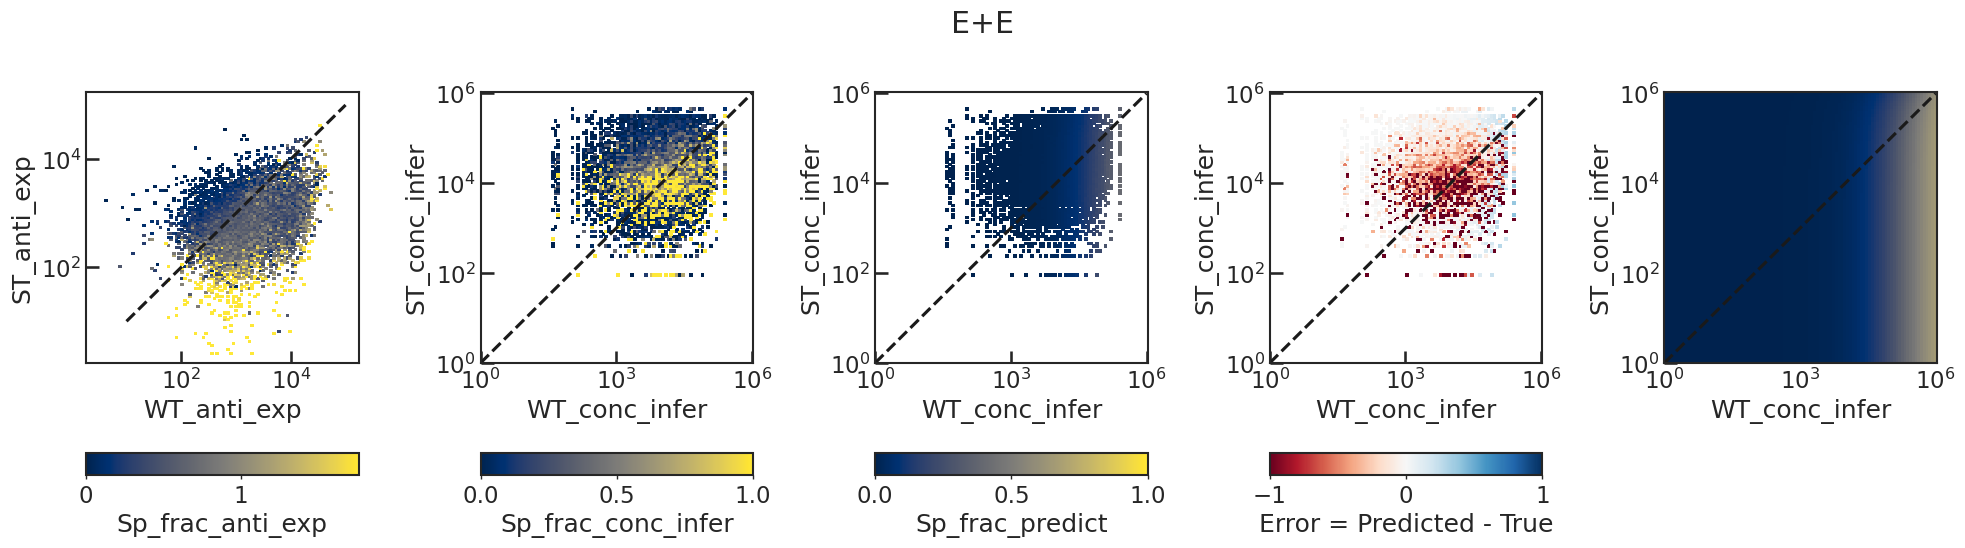

[2.35325642e-03 4.27061232e+00 5.60889895e+00]


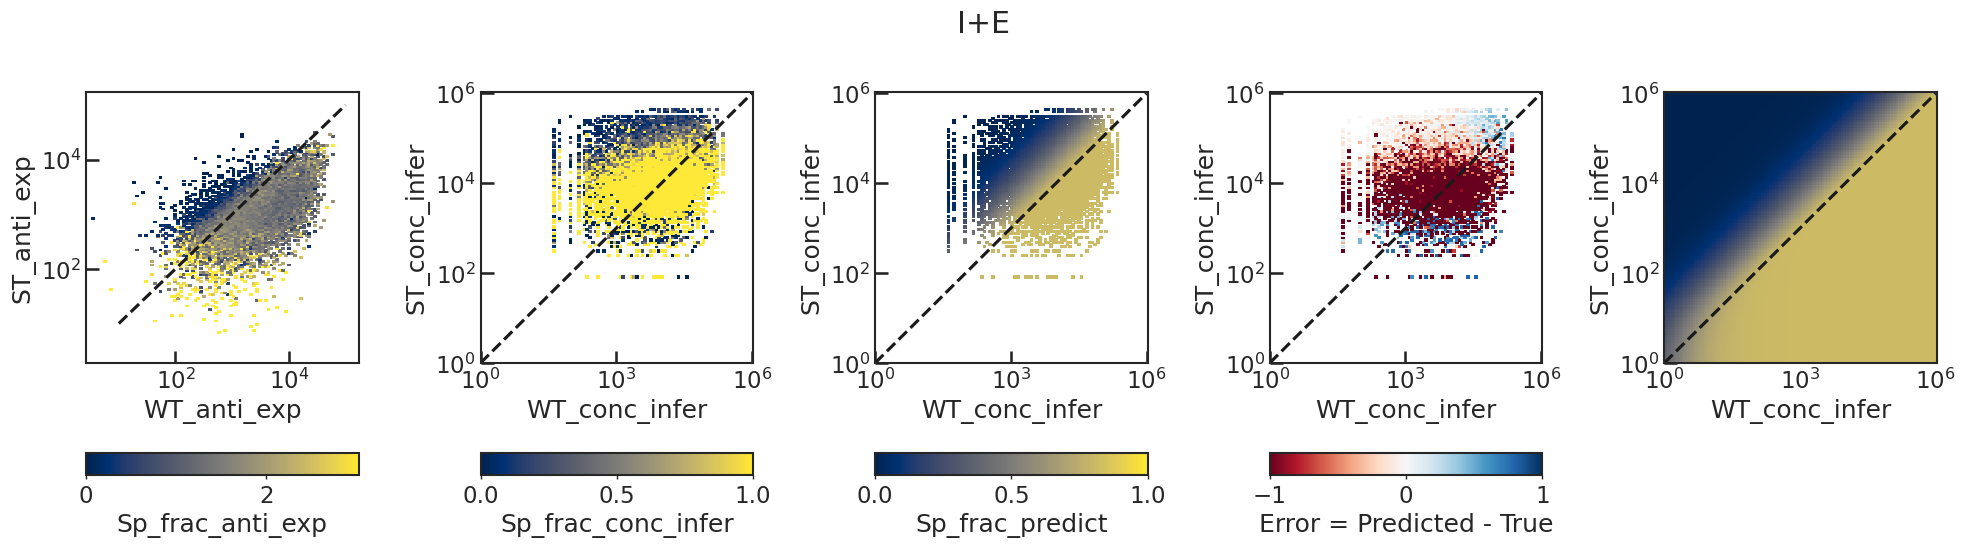

[2.35325642e-03 4.27061232e+00 3.62871517e+08]


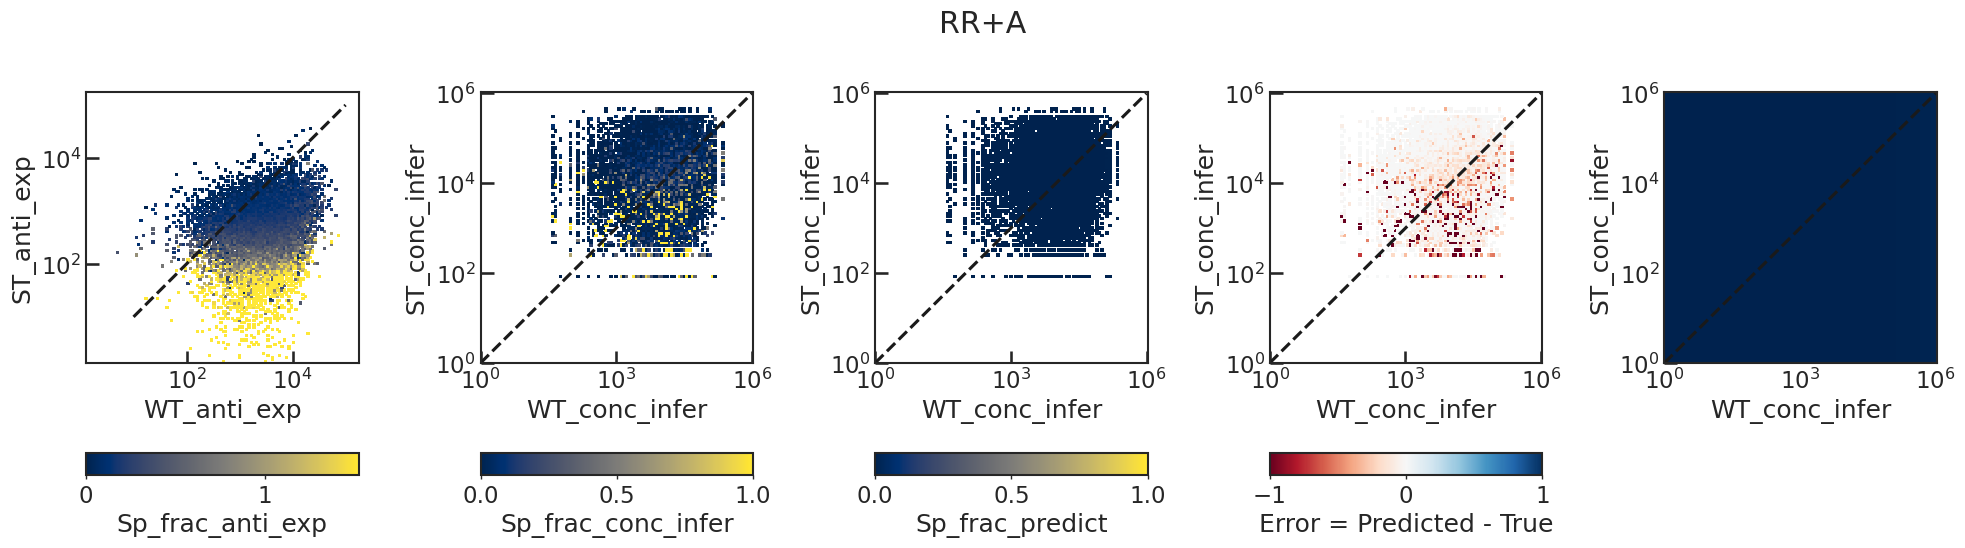

[2.35325642e-03 4.27061232e+00 1.69335278e+05]


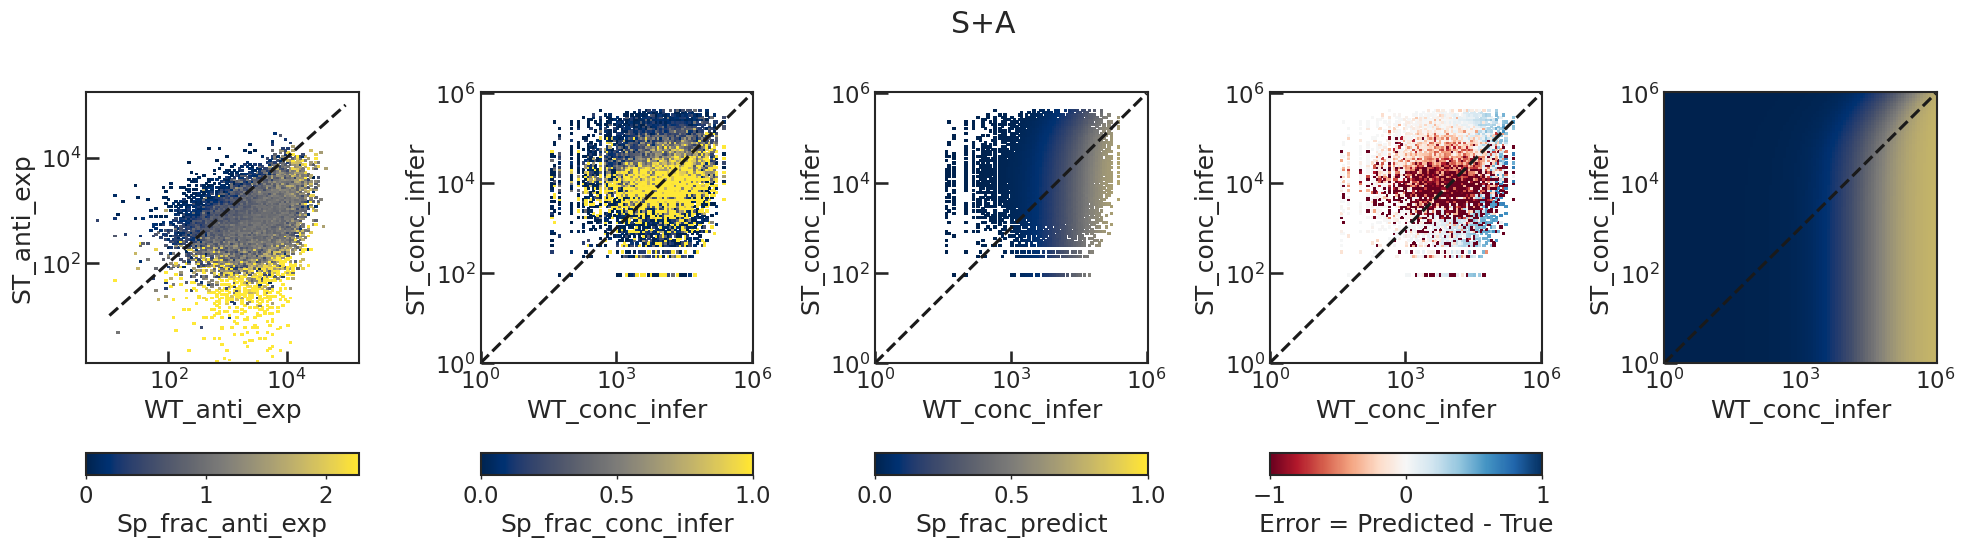

[2.35325642e-03 4.27061232e+00 4.37902860e+05]


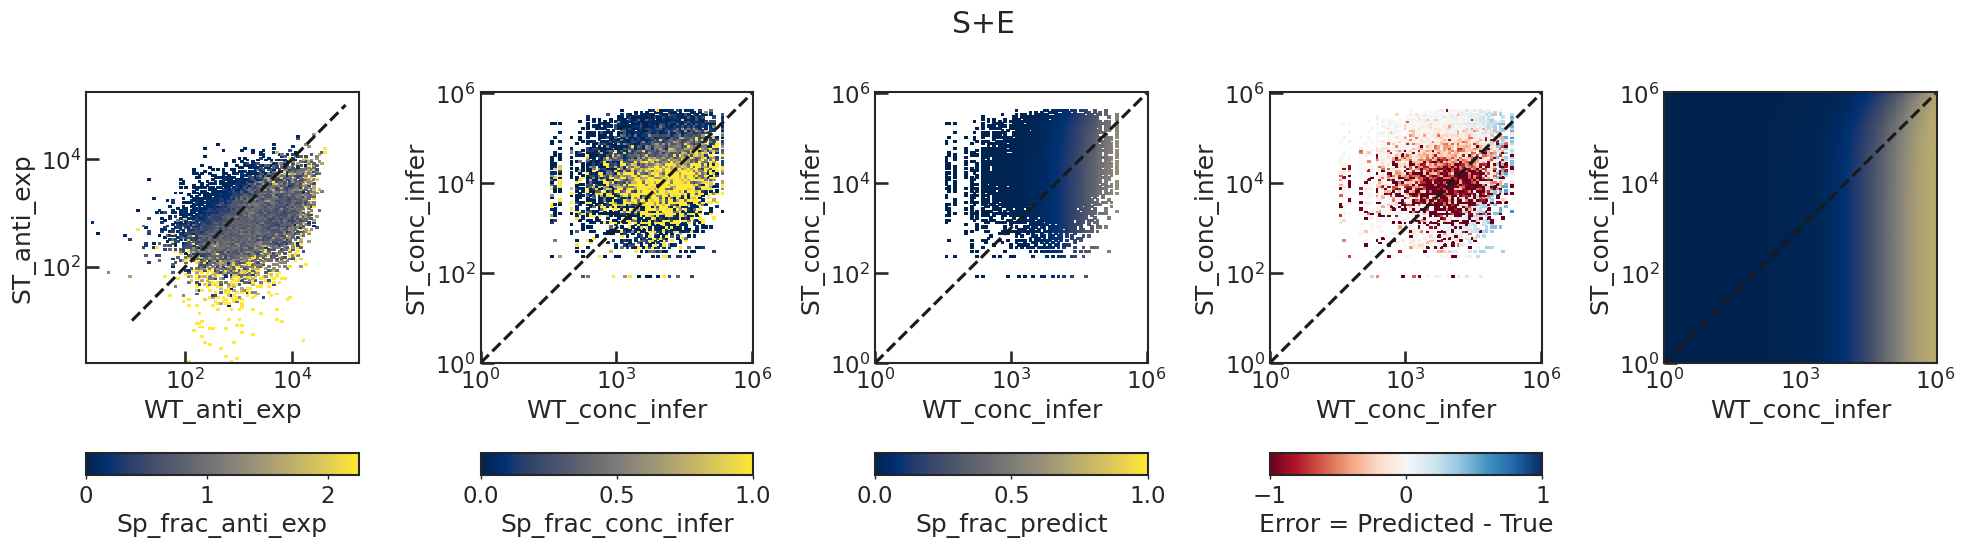

In [94]:



for i, (construct, group) in enumerate(df.groupby("dataset")):
    
    
#     noise_params = res.x[param_dict[construct][0:1]]
    model_params = 10**res.x[param_dict[construct][0:]]
    print(model_params)

    
    fig = plt.figure(figsize=(20, 4.5))
    
    axes = []
    
    fig.suptitle(construct)
    
    ax = fig.add_subplot(1, 5, 1)
    axes.append(ax)
    
    df_tmp = group.copy()
    
    hist, xedges = np.histogram(np.log10(df_tmp['WT_anti_exp']), bins='auto')
    hist, yedges = np.histogram(np.log10(df_tmp['ST_anti_exp']), bins='auto')
    xedges = 10**xedges
    yedges = 10**yedges

    df_tmp['xbin'] = pd.cut(df_tmp['WT_anti_exp'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_anti_exp'], yedges, labels=False)


    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_anti_exp'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm1 = mpl.colors.Normalize(vmin=0, vmax=group['Sp_frac_anti_exp'].quantile(0.95))
    cmap=plt.cm.cividis
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap, norm=norm1, rasterized=True)
    
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_anti_exp')
    ax.set_ylabel('ST_anti_exp')
    
    
    
    
    
    
    ax = fig.add_subplot(1, 5, 2)
    axes.append(ax)
    
    df_tmp = group.copy().dropna()
    
    hist, xedges = np.histogram(np.log10(df_tmp['WT_conc_infer']), bins='auto', range=(0, 6))
    hist, yedges = np.histogram(np.log10(df_tmp['ST_conc_infer']), bins='auto', range=(0, 6))
    xedges = 10**xedges
    yedges = 10**yedges

    df_tmp['xbin'] = pd.cut(df_tmp['WT_conc_infer'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_conc_infer'], yedges, labels=False)
    

    
    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_conc_infer'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm2 = mpl.colors.Normalize(vmin=0, vmax=1.0)
    cmap=plt.cm.cividis
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap, norm=norm2, rasterized=True)
    
    t = np.linspace(1e0, 1e6)
    ax.plot(t, t, 'k--')
    
#     ax.set_xlim(1e2, 1e6)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_conc_infer')
    ax.set_ylabel('ST_conc_infer')
        
        
    
    
    
    
    ax = fig.add_subplot(1, 5, 3, sharex=ax, sharey=ax)
    axes.append(ax)
    
    df_tmp = group.copy().dropna()
    
    hist, xedges = np.histogram(np.log10(df_tmp['WT_conc_infer']), bins='auto', range=(0, 6))
    hist, yedges = np.histogram(np.log10(df_tmp['ST_conc_infer']), bins='auto', range=(0, 6))
    xedges = 10**xedges
    yedges = 10**yedges

    df_tmp['xbin'] = pd.cut(df_tmp['WT_conc_infer'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_conc_infer'], yedges, labels=False)

    
    df_tmp['SpT_conc_predict'] = pp.PushAmp().predict_all(df_tmp[['WT_conc_infer', 'ST_conc_infer']].values, model_params)
    
    df_tmp['Sp_frac_predict'] = df_tmp['SpT_conc_predict'] / df_tmp['ST_conc_infer']

    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_predict'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
    cmap=plt.cm.cividis
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap, norm=norm, rasterized=True)
    
    t = np.linspace(1e0, 1e6)
    ax.plot(t, t, 'k--')
    
#     ax.set_xlim(1e2, 1e6)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_conc_infer')
    ax.set_ylabel('ST_conc_infer')
    
    
    
    
    
    ax = fig.add_subplot(1, 5, 4, sharex=ax, sharey=ax)
    axes.append(ax)
    
    df_tmp['error'] = df_tmp['Sp_frac_predict'] - df_tmp['Sp_frac_conc_infer']
    
    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['error'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm3 = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)
    cmap3=plt.cm.RdBu
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap3, norm=norm3, rasterized=True)
    
    t = np.linspace(1e0, 1e6)
    ax.plot(t, t, 'k--')
    
#     ax.set_xlim(1e2, 1e6)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_conc_infer')
    ax.set_ylabel('ST_conc_infer')
        
        
    
    
    
    
    ax = fig.add_subplot(1, 5, 5, sharex=ax, sharey=ax)
    axes.append(ax)
    
    X, Y = np.meshgrid(np.logspace(0, 6, 100, base=10), np.logspace(0, 6, 100, base=10))
    
    
    SpT_GFP_predict = pp.PushAmp().predict_all(np.asfortranarray(np.c_[X.flatten(), Y.flatten()]), np.array(model_params))[:, 0]
    
    Sp_frac_GFP_predict = SpT_GFP_predict / Y.flatten()
    
#     norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
    cmap=plt.cm.cividis
    
    ax.pcolormesh(X, Y, Sp_frac_GFP_predict.reshape(X.shape), cmap=cmap, norm=norm, rasterized=True, shading='auto')
    
    t = np.linspace(1e0, 1e6)
    ax.plot(t, t, 'k--')
    
#     ax.set_xlim(1e2, 1e6)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_conc_infer')
    ax.set_ylabel('ST_conc_infer')
        
    
    
    
        
    
    
    plt.tight_layout()
    
    
    
    bbox = axes[0].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm1, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Sp_frac_anti_exp")
    
    
    bbox = axes[1].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm2, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Sp_frac_conc_infer")
    
    
    bbox = axes[2].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Sp_frac_predict")
    
    
    bbox = axes[3].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap3, norm=norm3, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Error = Predicted - True")

    

    plt.show()
    

['I+E', 'S+A', 'S+E', 'E+E', 'RR+A']
[0.7488776154536765, 5.228747444813904, 5.641377781398362, 6.092874741930529, 8.55975287979738]


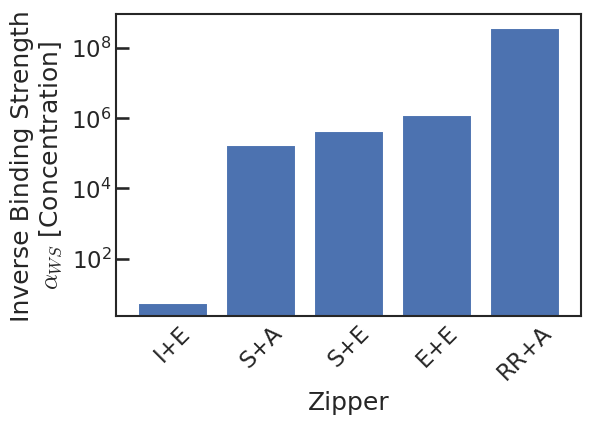

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

construct_list = list(param_dict.keys())

alphaWS_list = [res.x[param_dict[construct]][2] for construct in construct_list]

construct_list = [x for _, x in sorted(zip(alphaWS_list, construct_list))]
alphaWS_list = sorted(alphaWS_list)

print(construct_list)
print(alphaWS_list)

ax.bar(construct_list, 10**np.array(alphaWS_list))

ax.set_yscale('log')
ax.set_xlabel("Zipper")
ax.set_ylabel("Inverse Binding Strength\n" + r"$\alpha_{WS}$ [Concentration]")
plt.xticks(rotation=45)

plt.show()

[2.35325642e-03 4.27061232e+00 1.23843935e+06]
19703.612106
3800.6121060000005 99014.612106


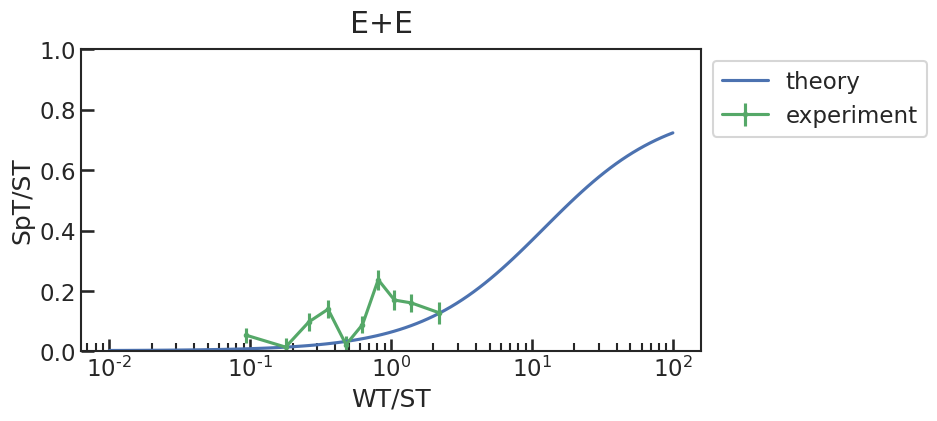

[2.35325642e-03 4.27061232e+00 5.60889895e+00]
19799.612106
3800.6121060000005 99014.612106


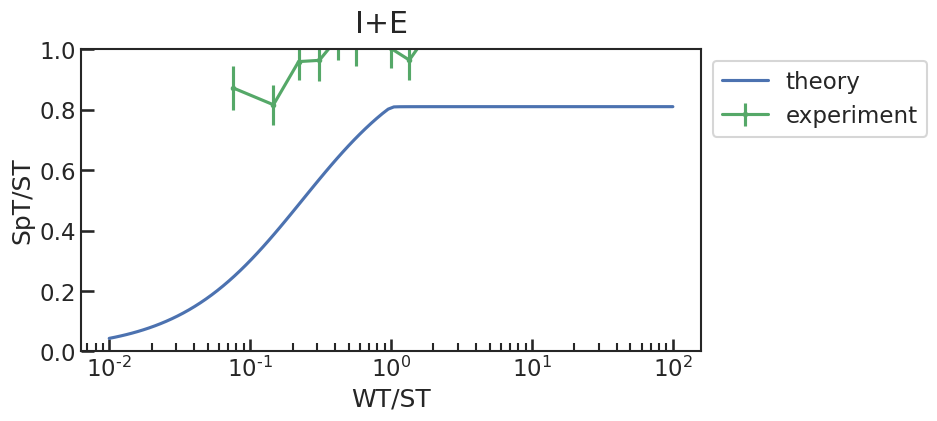

[2.35325642e-03 4.27061232e+00 3.62871517e+08]
18237.612106
3800.6121060000005 99014.612106


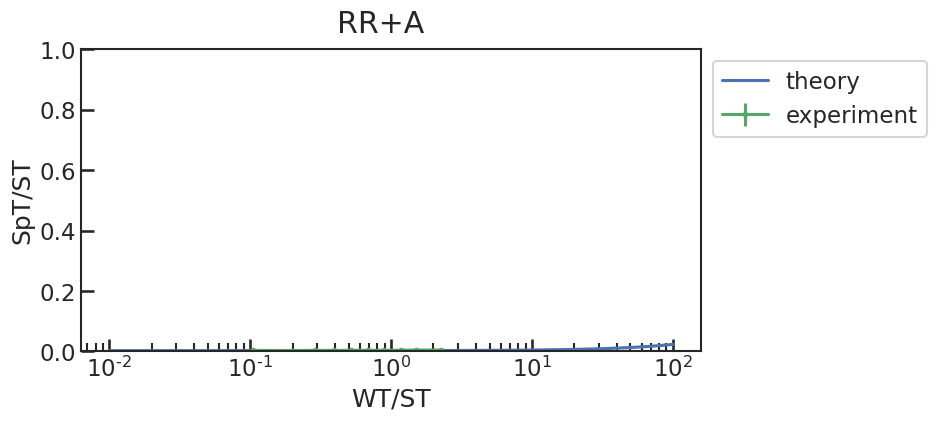

[2.35325642e-03 4.27061232e+00 1.69335278e+05]
19092.612106
3800.6121060000005 99014.612106


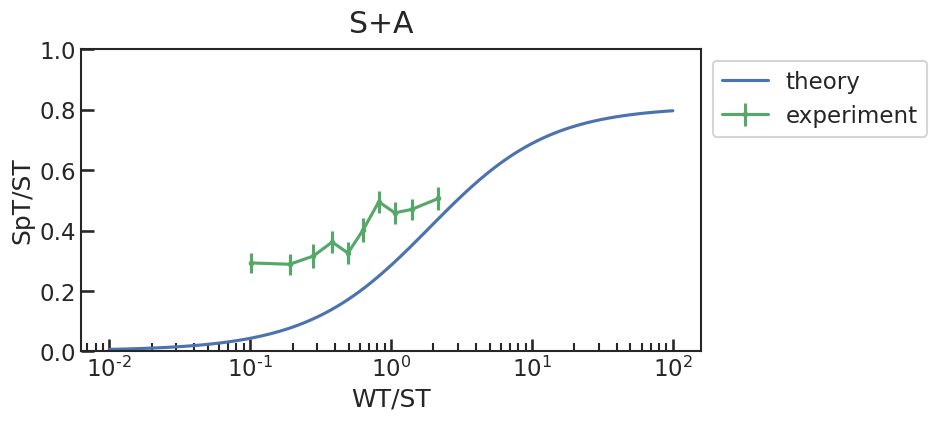

[2.35325642e-03 4.27061232e+00 4.37902860e+05]
19811.612106
3800.6121060000005 99014.612106


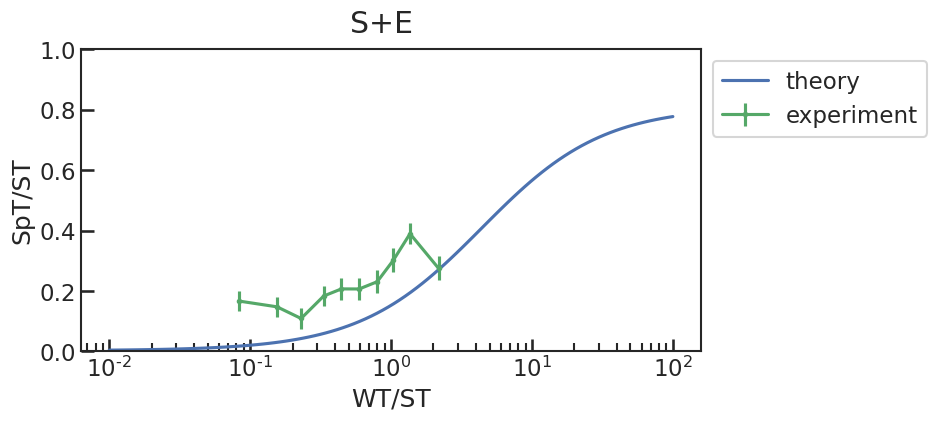

In [166]:
for i, (construct, group) in enumerate(df.groupby("dataset")):
    
    
#     noise_params = res.x[param_dict[construct][0:1]]
    model_params = 10**res.x[param_dict[construct][0:]]
    
    print(model_params)

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    
    fig.suptitle(construct)
    
    ST_median = np.median(group['ST_conc_infer'])
    
    print(ST_median)
    
    ST = ST_median*np.ones(100)
    WT = np.logspace(np.log10(ST_median)-2, np.log10(ST_median)+2, 100, base=10)
    
    SpT = pp.PushAmp().predict_all(np.asfortranarray(np.c_[WT, ST]), np.array(model_params))[:, 0]
    
    ax.plot(WT/ST, SpT/ST, 'b', label="theory")
    
    
    
    
# #     df_tmp = group.query("SpT_conc <= ST_conc").copy().dropna()
#     df_tmp = group.copy().dropna()
#     df_tmp['ratio'] = df_tmp['WT_conc_infer'] / df_tmp['ST_conc_infer']
    
#     bin_labels, edges = pd.qcut(df_tmp['ratio'], 16, labels=False, retbins=True)
    
#     df_tmp['bin'] = bin_labels
    
#     Sp_frac = df_tmp.groupby('bin')['Sp_frac_conc_infer'].mean() 
#     Sp_frac_err = df_tmp.groupby('bin')['Sp_frac_conc_infer'].sem()
    
#     ax.errorbar((edges[1:]+edges[0:len(edges)-1])/2, Sp_frac, yerr=Sp_frac_err, fmt='g.-', label="experiment", ms=6.0)
    
    
    ST_upper = group['ST_conc_infer'].quantile(0.6)
    ST_lower = group['ST_conc_infer'].quantile(0.4)
    
    SpT_upper = group['SpT_conc_infer'].quantile(0.90)
    SpT_lower = group['SpT_conc_infer'].quantile(0.1)
    
    WT_upper = group['WT_conc_infer'].quantile(0.90)
    WT_lower = group['WT_conc_infer'].quantile(0.1)
    
    print(lower, upper)
    
    df_tmp = group.query("ST_conc_infer < @ST_upper and ST_conc_infer > @ST_lower and SpT_conc_infer < @SpT_upper and SpT_conc_infer > @SpT_lower and WT_conc_infer < @WT_upper and WT_conc_infer > @WT_lower").copy().dropna()
#     df_tmp = group.copy().dropna()
    df_tmp['ratio'] = df_tmp['WT_conc_infer'] / df_tmp['ST_conc_infer']
    
    bin_labels, edges = pd.qcut(df_tmp['ratio'], 10, labels=False, retbins=True)
    
    df_tmp['bin'] = bin_labels
    
    Sp_frac = df_tmp.groupby('bin')['Sp_frac_conc_infer'].median() 
    Sp_frac_err = df_tmp.groupby('bin')['Sp_frac_conc_infer'].sem()
    
    ax.errorbar(np.sqrt(edges[1:]*edges[0:len(edges)-1]), Sp_frac, yerr=Sp_frac_err, fmt='g.-', label="experiment", ms=6.0)
    
    ax.set_xscale('log')
    
    ax.set_ylim(0, 1.0)
    
    ax.set_ylabel("SpT/ST")
    ax.set_xlabel("WT/ST")
    
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0, 0.0, 0.0))
    
    plt.show()

0.0 3854.612106
4.0 9006.612106
8.0 12781.612106
12.0 16750.612106
16.0 23099.612106
20.0 30859.612106
24.0 56007.612106
28.0 243582.612106


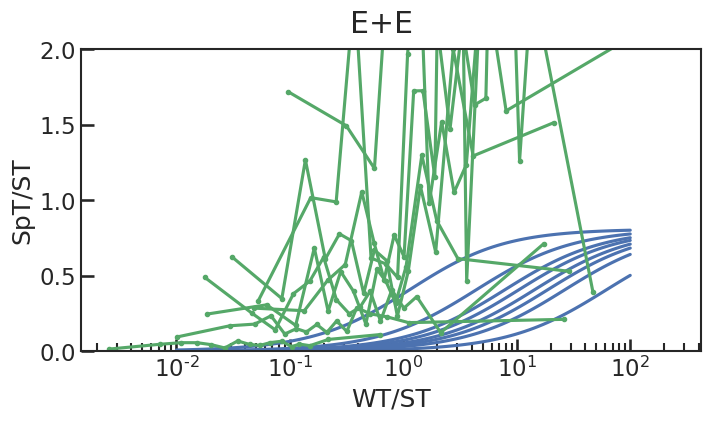

0.0 3660.612106
4.0 9006.612106
8.0 12211.612106
12.0 16373.612106
16.0 23099.612106
20.0 33841.612106
24.0 56007.612106
28.0 237670.612106


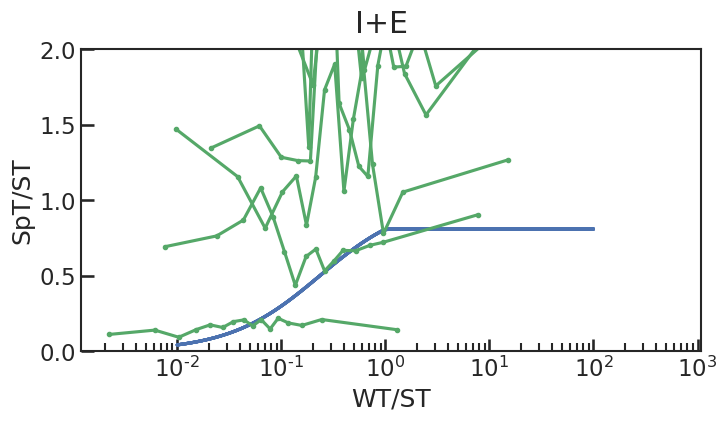

0.0 3660.612106
4.0 8226.612106
8.0 11828.612106
12.0 16665.612106
16.0 22685.612106
20.0 30859.612106
24.0 53752.612106
28.0 243582.612106


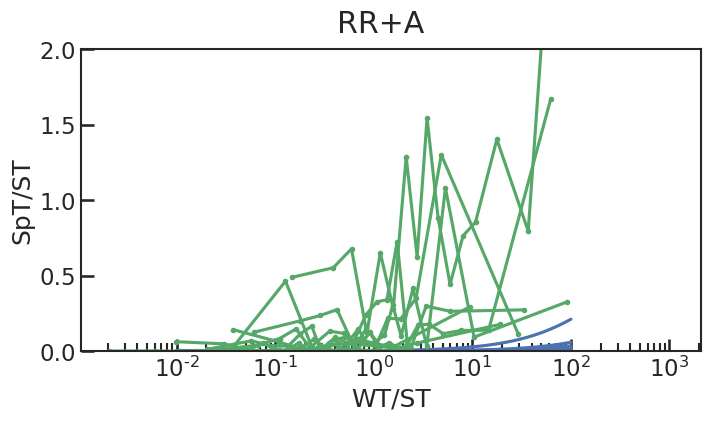

0.0 3854.612106
4.0 8226.612106
8.0 11828.612106
12.0 16665.612106
16.0 23099.612106
20.0 33841.612106
24.0 56007.612106
28.0 243582.612106


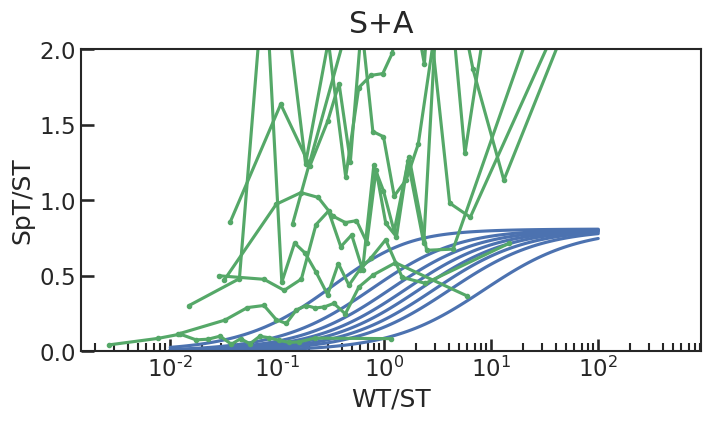

0.0 3854.612106
4.0 9006.612106
8.0 12211.612106
12.0 16750.612106
16.0 22685.612106
20.0 34994.612106
24.0 56007.612106
28.0 237670.612106


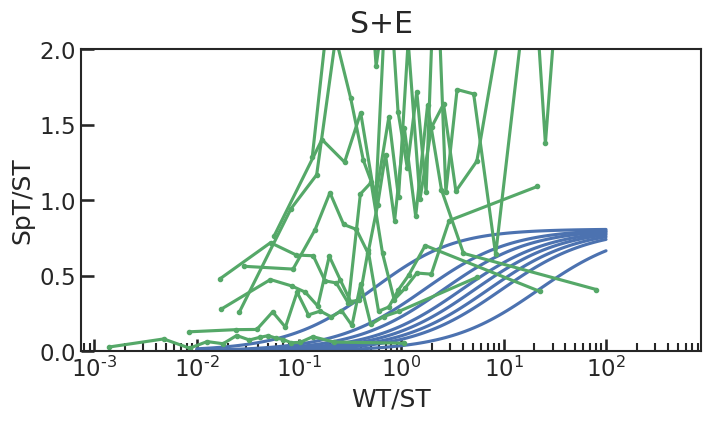

In [133]:
for i, (construct, group) in enumerate(df.groupby("dataset")):
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    fig.suptitle(construct)
    
    for ST_bin, groupb in group.groupby('ST_GFP_bin'):
        
        
        if ST_bin % 4 != 0:
            continue
            
            
        ST_median = np.median(groupb['ST_conc_infer'].values)
            
        print(ST_bin, ST_median)

    # #     noise_params = res.x[param_dict[construct][0:1]]
        model_params = 10**res.x[param_dict[construct][0:]]

    #     print(model_params)

      

        ST = ST_median*np.ones(100)
        WT = np.logspace(np.log10(ST_median)-2, np.log10(ST_median)+2, 100, base=10)

        SpT = pp.PushAmp().predict_all(np.asfortranarray(np.c_[WT, ST]), np.array(model_params))[:, 0]

        ax.plot(WT/ST, SpT/ST, 'b', label="theory")




        #     df_tmp = group.query("SpT_conc <= ST_conc").copy().dropna()
        df_tmp = groupb.copy().dropna()
        df_tmp['ratio'] = df_tmp['WT_conc_infer'] / df_tmp['ST_conc_infer']

        bin_labels, edges = pd.qcut(df_tmp['ratio'], 16, labels=False, retbins=True)

        df_tmp['bin'] = bin_labels

        Sp_frac = df_tmp.groupby('bin')['Sp_frac_conc_infer'].mean() 
        Sp_frac_err = df_tmp.groupby('bin')['Sp_frac_conc_infer'].sem()

        ax.errorbar((edges[1:]+edges[0:len(edges)-1])/2, Sp_frac, yerr=0, fmt='g.-', label="experiment", ms=6.0)


    ax.set_xscale('log')

    ax.set_ylim(0, 2.0)

    ax.set_ylabel("SpT/ST")
    ax.set_xlabel("WT/ST")

    #     ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0, 0.0, 0.0))

    plt.show()